# Analysis of mouse single cell hematopoietic populations - Hierarchical clustering of index sorted CMP
__Author__: Elisabeth F. Heuston

## Purpose

Single cell transcriptional and clustering analysis of LSK, CMP, MEP, and GMP data presented in Heuston et al., 2021  

This notebook contains the workflow to analyze data from Scanpy-derived analyses and pertains to:

* Supplemental Figure 6B  

Raw data for this publication are available to download from the GEO Project GSE168260 at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE168259  

## Workbook setup

## Load modules

In [37]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter, ExcelFile
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from pylab import savefig
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import axes3d, Axes3D
import os
import re

%matplotlib inline

## User-defined functions


In [2]:
def generate_probe_statistics(df, sheetname, writer):
    stats_table=pd.DataFrame()
    stats_table['Failed Probe'] = df.sum(axis=1)==0
    stats_table['sum'] = df.sum(axis=1).round(2)
    stats_table['min Ct'] = df.min(axis=1).round(2)
    stats_table['max Ct'] = df.max(axis=1).round(2)
    stats_table['mean Ct'] = biomark_ctIndexed.mean(axis=1).round(2)
    stats_table['median Ct'] = df.median(axis=1).round(2)
    stats_table['Ct std'] = df.std(axis=1).round(2)
    stats_table.to_excel(writer, sheetname)

In [3]:
def invert_ct(x):
    if x>0:
        return (1/x)
    else:
        return(0)

In [4]:
def apply_ct_limits(x):
    if x < 8 or x > 32:
        return 0
    else:
        return x

In [5]:
def plate_preprocessing(plate):
    plate.columns = ['Well ID', 'Probe', 'Ct', 'Call']
    plate.loc[plate['Call'] == 'Flag', 'Ct'] = 0
    plate['Ct'] = plate['Ct'].replace(999.0, np.nan)
    plate['Ct'] = plate['Ct'].apply(lambda x: apply_ct_limits(x))
    plate['Ct']= plate['Ct'].apply(lambda x: invert_ct(x))
    plate.drop(['Call'], axis=1, inplace=True)
    plate = plate.set_index(['Well ID', 'Probe'])
    plate = plate.unstack(level = 'Well ID')
    plate.columns = plate.columns.droplevel()
    plate.dropna(axis = 1, how = 'all', inplace = True)
    return plate

In [6]:
def plate_normalization(plate):
    column_mean = plate.mean(axis = 0, skipna = True)
    column_std = plate.std(axis = 0, skipna = True)
    plate = plate.sub(column_mean, axis = 1)
    plate = plate.div(column_std, axis = 1)
    column_min = plate.min(axis = 0, skipna = True)
    plate = plate.sub(column_min, axis = 1)
    return plate

In [7]:
def flow_normalization(plate):
    column_mean = plate.mean(axis = 0, skipna = True)
    column_std = plate.std(axis = 0, skipna = True)
    plate = plate.sub(column_mean, axis = 1)
    plate = plate.div(column_std, axis = 1)
    column_min = plate.min(axis = 0, skipna = True)
    plate = plate.sub(column_min, axis = 1)
    plate.fillna(0, inplace = True)
    return plate  

In [8]:
def binning_flow(indexStats_column):
    if indexStats_column.mean() !=0:
        flow_bins = [-np.inf, 0, indexStats_column.mean(), indexStats_column.mean()+2*indexStats_column.std(), np.inf]
        flow_labels = [0,1,2,3]
    elif indexStats_column.mean() == 0:
        if indexStats_column.std() ==0:
            flow_bins = [-np.inf, np.inf]
            flow_labels = [0]
        elif indexStats_column.std() !=0:
            flow_bins = [-np.inf, indexStats_column.mean(), indexStats_column.mean()+2*indexStats_column.std(), np.inf]
            flow_labels = [0, 1, 2]
    else:
        return
    binned_flow = pd.cut(indexStats_column, bins = flow_bins, labels = flow_labels)
    return pd.Series(binned_flow)

In [9]:
def join_biomarkData(new_dataframe, RT_data, Flow_data):
    RT_data = RT_data.transpose()
    RT_data.sort_index(inplace = True)
    RT_index_names = RT_data.index.values
    Flow_data = Flow_data[Flow_data.index.isin(RT_index_names)]
    new_dataframe = pd.concat([RT_data, Flow_data], axis = 1, sort = True, join = 'inner')
    new_dataframe.head()
    return new_dataframe

In [10]:
def plate_preprocessing_transpose(plate):
    plate.columns = ['Well ID', 'Probe', 'Ct', 'Call']
    plate['Ct'] = plate['Ct'].replace(999.0, np.nan)
    plate['Ct']= plate['Ct'].apply(lambda x: invert_ct(x))
    plate.drop(['Call'], axis=1, inplace=True)
    plate = plate.set_index(['Well ID', 'Probe'])
    plate = plate.unstack(level = 'Well ID')
    plate.columns = plate.columns.droplevel()
    plate.dropna(axis = 1, how = 'all', inplace = True)
    plate = plate.transpose()
    return plate

In [11]:
heatmap_colors = sns.cubehelix_palette(n_colors = 10, start = 0.5, rot = -0.8, gamma = 0.6, hue = 1.00, light = .9, dark = 0, reverse = True)

### Pool cytometry and probe data and create heatmaps

In [60]:
flow_data = pd.ExcelFile("BioMark_MFI.xlsx")

In [63]:
cmp_indexStats = pd.read_excel("BioMark_MFI.xlsx", index_col=0)
cmp_indexStats = flow_normalization(cmp_indexStats)

In [64]:
cmp_indexStats

,Live_deadneg,CD34pos,CD16_32neg,cKitpos,CD9pos,CD36pos,CD41pos,CD48pos,CD123pos,CD150pos,Flk2pos
Well ID,,,,,,,,,,,
CMP_a1_bp2,2.114278,1.085682,3.422749,0.000000,0.000000,0.0,0.000000,1.990540,0.000000,0.0,0.000000
CMP_a2_bp2,2.284418,1.085682,2.878989,0.000000,0.028695,0.0,0.000000,2.762328,0.000000,0.0,0.000000
CMP_a3_bp2,1.719730,0.960803,2.148700,0.000000,0.000000,0.0,0.000000,1.698967,0.000000,0.0,3.662543
CMP_a4_bp2,2.625431,1.541872,2.600892,0.000000,0.000000,0.0,0.000000,1.913043,0.000000,0.0,0.979873
CMP_a5_bp2,2.246528,1.401702,3.038387,0.000000,0.000000,0.0,0.000000,2.959316,0.000000,0.0,6.363781
...,...,...,...,...,...,...,...,...,...,...,...
CMP_h8_p7,2.721990,1.126458,0.488027,2.740007,0.000000,0.0,0.000000,2.480161,0.275052,0.0,1.073300
CMP_h9_p7,2.857662,0.356797,0.731080,0.582480,0.000000,0.0,0.025137,1.190403,0.000000,0.0,0.000000
CMP_h10_p7,1.888159,0.152913,0.052793,2.800091,0.215901,0.0,0.000000,1.598420,0.000000,0.0,0.000000


In [62]:
cmp_indexStats = pd.DataFrame([])
for i in flow_data_xl.sheet_names:
    if '_CMP' in i:
        flow_data_cls = flow_data_xl.parse(i, index_col=0)
        flow_data_cls = flow_normalization(flow_data_cls)
        cmp_indexStats = cmp_indexStats.append(flow_data_cls)

TypeError: read_excel() missing 1 required positional argument: 'io'

# Read cycle threshold (ct)

In [14]:
plate1 = pd.read_excel("BioMarkData.xlsx", sheet_name="Plate1", skiprows=11, usecols="B, E, G, I")
plate1["Name"] = plate1["Name"].astype(str) + '_p1'
plate1 = plate_preprocessing_transpose(plate1)
plate1 = plate_normalization(plate1)

plate2 = pd.read_excel("BioMarkData.xlsx", sheet_name="Plate2", skiprows=11, usecols="B, E, G, I")
plate2["Name"] = plate2["Name"].astype(str) + '_p2'
plate2 = plate_preprocessing_transpose(plate2)
plate2 = plate_normalization(plate2)

plate3 = pd.read_excel("BioMarkData.xlsx", sheet_name="Plate3", skiprows=11, usecols="B, E, G, I")
plate3["Name"] = plate3["Name"].astype(str) + '_p3'
plate3 = plate_preprocessing_transpose(plate3)
plate3 = plate_normalization(plate3)

plate4 = pd.read_excel("BioMarkData.xlsx", sheet_name="Plate4", skiprows=11, usecols="B, E, G, I")
plate4["Name"] = plate4["Name"].astype(str) + '_p4'
plate4 = plate_preprocessing_transpose(plate4)
plate4 = plate_normalization(plate4)

plate5 = pd.read_excel("BioMarkData.xlsx", sheet_name="Plate5", skiprows=11, usecols="B, E, G, I")
plate5["Name"] = plate5["Name"].astype(str) + '_p5'
plate5 = plate_preprocessing_transpose(plate5)
plate5 = plate_normalization(plate5)

plate6 = pd.read_excel("BioMarkData.xlsx", sheet_name="Plate6", skiprows=11, usecols="B, E, G, I")
plate6["Name"] = plate6["Name"].astype(str) + '_p6'
plate6 = plate_preprocessing_transpose(plate6)
plate6 = plate_normalization(plate6)

plate7 = pd.read_excel("BioMarkData.xlsx", sheet_name="Plate7", skiprows=11, usecols="B, E, G, I")
plate7["Name"] = plate7["Name"].astype(str) + '_p7'
plate7 = plate_preprocessing_transpose(plate7)
plate7 = plate_normalization(plate7)

plate8 = pd.read_excel("BioMarkData.xlsx", sheet_name="Plate8", skiprows=11, usecols="B, E, G, I")
plate8["Name"] = plate8["Name"].astype(str) + '_p8'
plate8 = plate_preprocessing_transpose(plate8)
plate8 = plate_normalization(plate8)

Before, normalized all genes w/in cell. Now will normalize all cells within gene...?

In [28]:
Plate7.loc['CMP_a10_p7', 'AA467197']

3.3854039739642596

In [15]:
plate7.loc['CMP_a10_p7', 'AA467197']

3.3854039739642596

In [17]:
biomark_ct=pd.concat([plate1, plate2, plate3, plate4, plate5, plate6, plate7, plate8], axis = 0, sort = True)
biomark_ct.fillna(0, inplace = True)
biomark_ct.head(2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Slpi,Tek,Tfrc,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,2.649990,1.77373,2.019433,0.0,0.000000,1.339503,0.0,0.0,2.57031,2.368744,...,0.0,0.0,0.0,3.552514,2.049859,1.502776,2.134494,1.993980,1.726231,2.867860
CMP_a2_p1,2.804249,0.00000,2.230499,0.0,1.928265,0.000000,0.0,0.0,2.42429,2.177404,...,0.0,0.0,0.0,0.000000,1.706680,0.000000,1.555245,2.298848,1.713173,2.523891


In [29]:
biomark_ct=pd.concat([plate1, plate2, plate3, plate4, plate5, plate6, Plate7, Plate8], axis = 0, sort = True)
biomark_ct.fillna(0, inplace = True)
biomark_ct.head(2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Slpi,Tek,Tfrc,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,2.649990,1.77373,2.019433,0.0,0.000000,1.339503,0.0,0.0,2.57031,2.368744,...,0.0,0.0,0.0,3.552514,2.049859,1.502776,2.134494,1.993980,1.726231,2.867860
CMP_a2_p1,2.804249,0.00000,2.230499,0.0,1.928265,0.000000,0.0,0.0,2.42429,2.177404,...,0.0,0.0,0.0,0.000000,1.706680,0.000000,1.555245,2.298848,1.713173,2.523891


In [29]:
biomark_ct=pd.concat([plate1, plate2, plate3, plate4, plate5, plate6, Plate7, Plate8], axis = 0, sort = True)
biomark_ct.fillna(0, inplace = True)
biomark_ct.head(2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Slpi,Tek,Tfrc,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,2.649990,1.77373,2.019433,0.0,0.000000,1.339503,0.0,0.0,2.57031,2.368744,...,0.0,0.0,0.0,3.552514,2.049859,1.502776,2.134494,1.993980,1.726231,2.867860
CMP_a2_p1,2.804249,0.00000,2.230499,0.0,1.928265,0.000000,0.0,0.0,2.42429,2.177404,...,0.0,0.0,0.0,0.000000,1.706680,0.000000,1.555245,2.298848,1.713173,2.523891


In [19]:
biomark_ct = biomark_ct.loc[:, ~(biomark_ct==0).all(axis = 0)]
biomark_ct = biomark_ct.loc[~(biomark_ct==0).all(axis = 1)]

In [16]:
biomark_ct=pd.concat([plate1, plate2, plate3, plate4, plate5, plate6, plate7, plate8], axis = 0, sort = True)
biomark_ct.fillna(0, inplace = True)
biomark_ct.head(2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Slpi,Tek,Tfrc,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,2.649990,1.77373,2.019433,0.0,0.000000,1.339503,0.0,0.0,2.57031,2.368744,...,0.0,0.0,0.0,3.552514,2.049859,1.502776,2.134494,1.993980,1.726231,2.867860
CMP_a2_p1,2.804249,0.00000,2.230499,0.0,1.928265,0.000000,0.0,0.0,2.42429,2.177404,...,0.0,0.0,0.0,0.000000,1.706680,0.000000,1.555245,2.298848,1.713173,2.523891


In [26]:
biomark_ct.head()

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Slpi,Tek,Tfrc,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,2.649990,1.773730,2.019433,0.0,0.000000,1.339503,0.0,0.0,2.57031,2.368744,...,0.0,0.000000,0.0,3.552514,2.049859,1.502776,2.134494,1.993980,1.726231,2.867860
CMP_a2_p1,2.804249,0.000000,2.230499,0.0,1.928265,0.000000,0.0,0.0,2.42429,2.177404,...,0.0,0.000000,0.0,0.000000,1.706680,0.000000,1.555245,2.298848,1.713173,2.523891
CMP_a3_p1,2.561454,0.000000,0.000000,0.0,0.000000,1.585613,0.0,0.0,0.00000,1.944766,...,0.0,3.540561,0.0,0.000000,2.106933,1.585682,2.562803,1.039019,0.000000,1.624024
CMP_a4_p1,2.074138,1.285820,2.122999,0.0,1.609724,0.000000,0.0,0.0,1.95625,2.844949,...,0.0,0.000000,0.0,0.000000,1.679931,1.435995,1.901947,1.430460,1.142821,2.200736
CMP_a5_p1,2.837858,2.095588,1.354796,0.0,0.000000,1.938701,0.0,0.0,0.00000,1.992103,...,0.0,0.000000,0.0,0.000000,1.402727,2.226133,3.092767,2.137777,1.810997,2.821189


In [23]:
cmpbiomarkT = biomark_ct.filter(regex = 'CMP', axis = 0)

In [24]:
def join_biomarkData_v2(new_dataframe, RT_data, Flow_data):
    RT_data = RT_data
    RT_data.sort_index(inplace = True)
    RT_index_names = RT_data.index.values
    Flow_data = Flow_data[Flow_data.index.isin(RT_index_names)]
    new_dataframe = pd.concat([RT_data, Flow_data], axis = 1, sort = True, join = 'inner')
    new_dataframe.head()
    return new_dataframe

In [25]:
# Integrate CMP biomark and flow data
cmp_integrated = pd.DataFrame([])
cmp_integrated = join_biomarkData_v2(cmp_integrated, cmpbiomarkT.copy(), cmp_indexStats.copy())
print("\nCMP integrated dataframe ", cmp_integrated.shape)

NameError: name 'cmp_indexStats' is not defined

/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


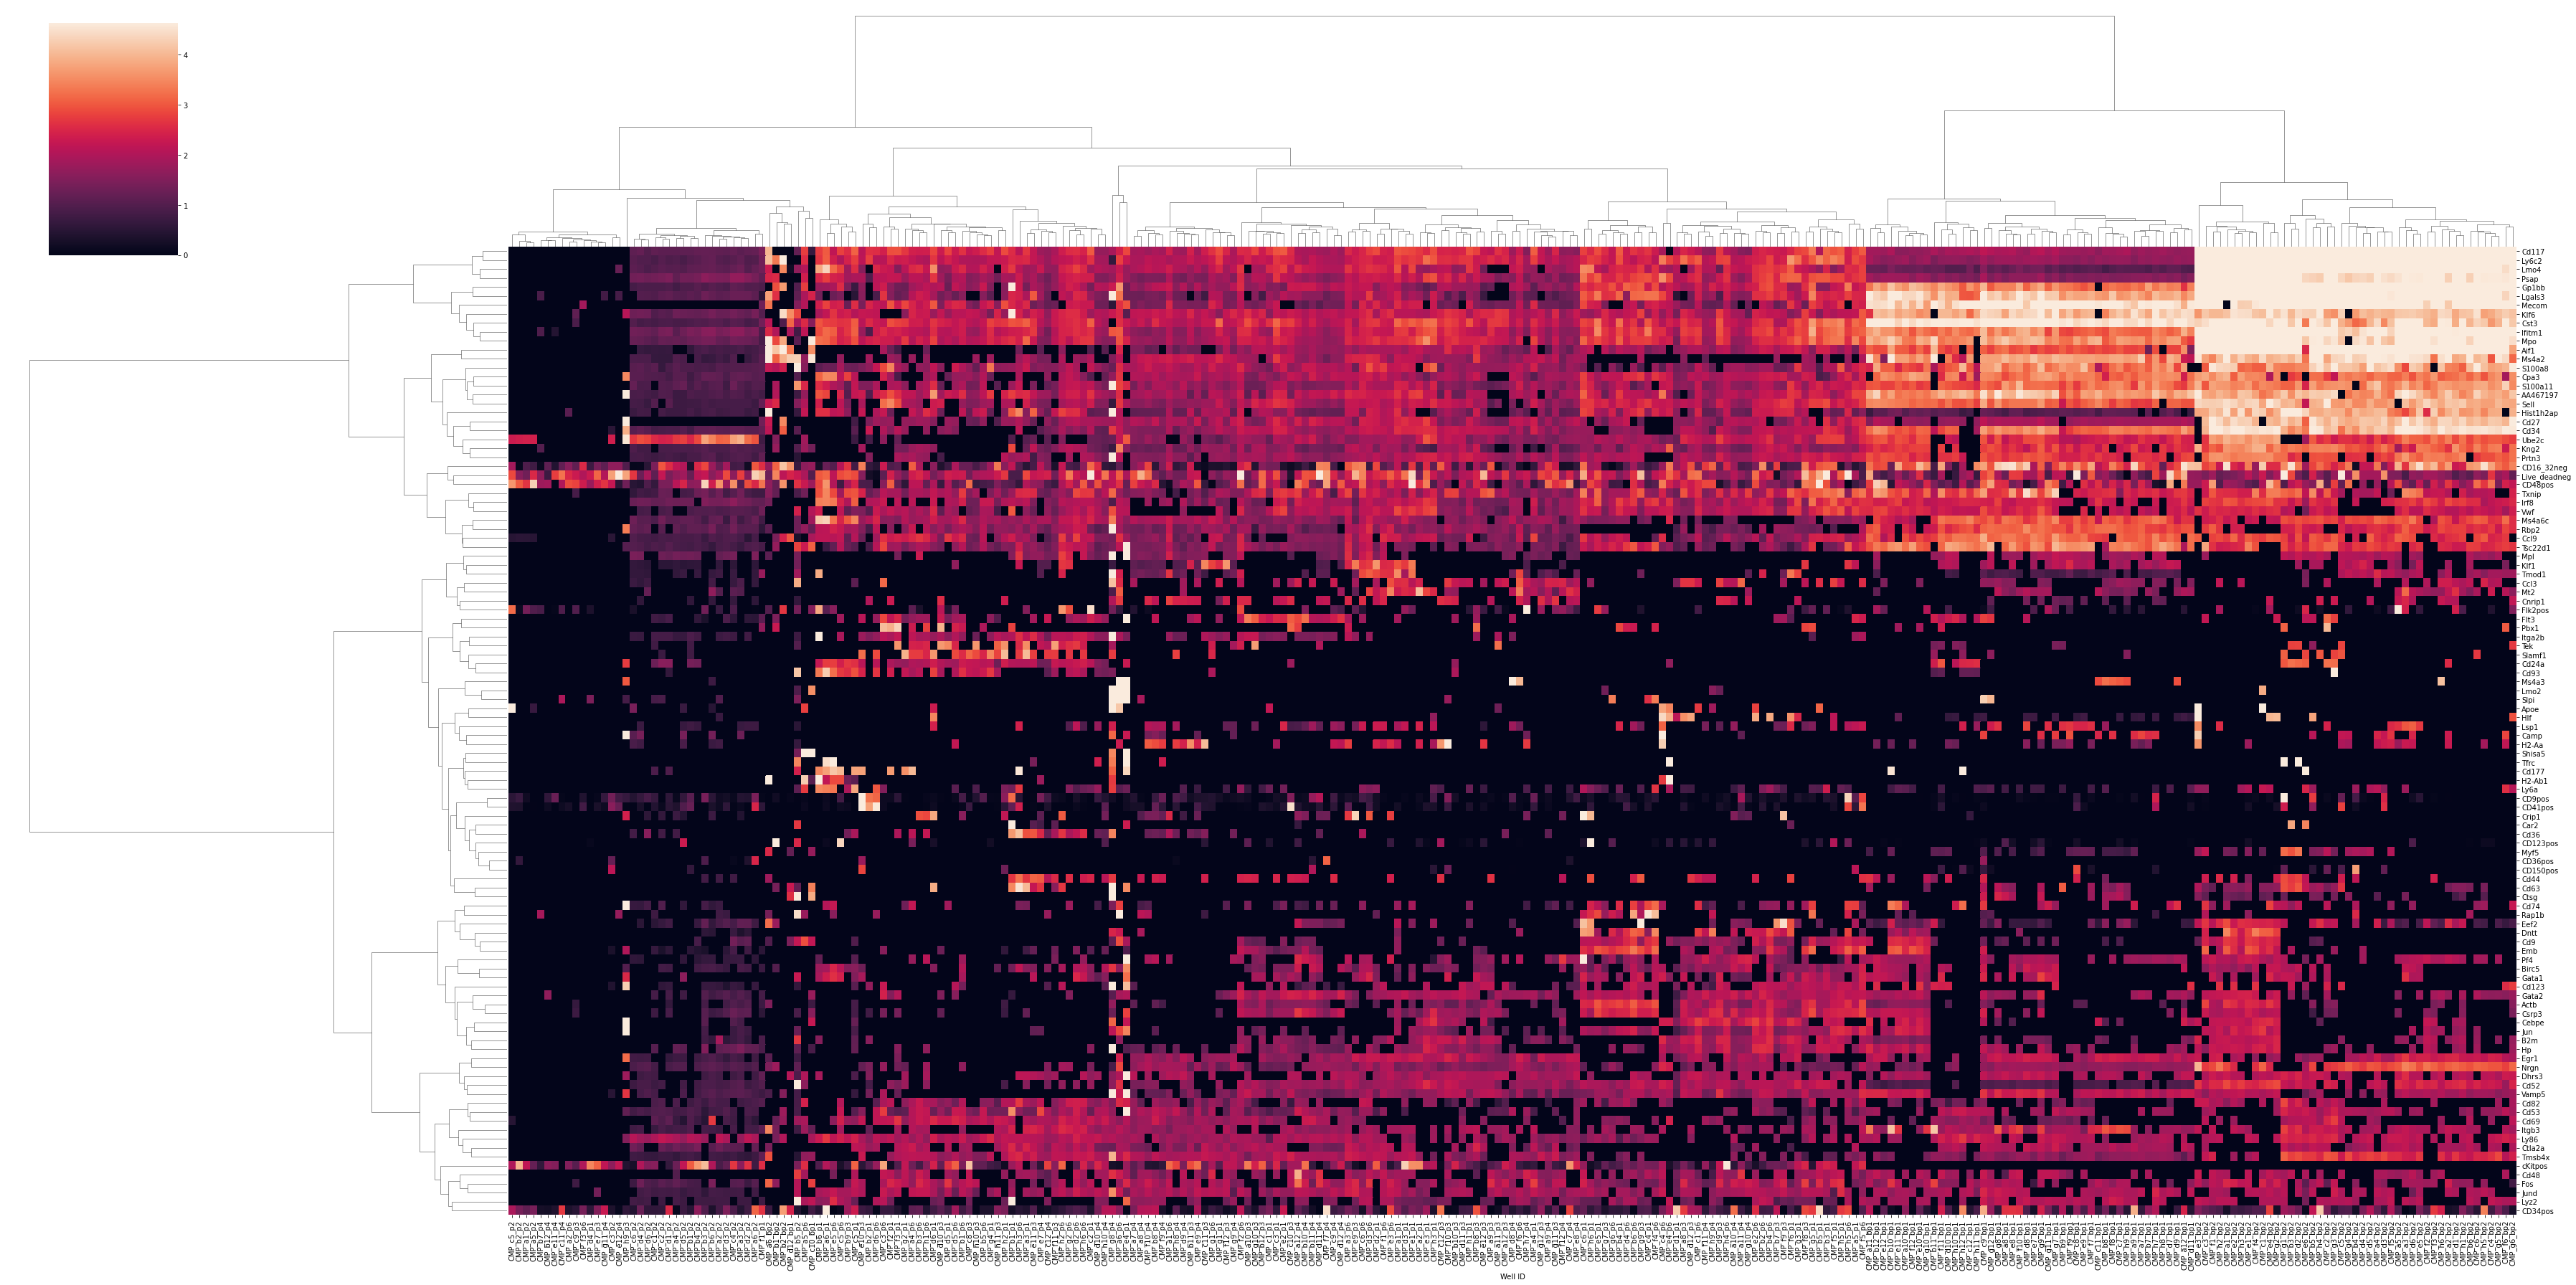

In [46]:
sns.clustermap(cmp_integrated.transpose(), figsize=(50,25), method = 'ward', robust = True, xticklabels = True, yticklabels = True)
# savefig("CMP_integratedT_norm.png", dpi = 400)

/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


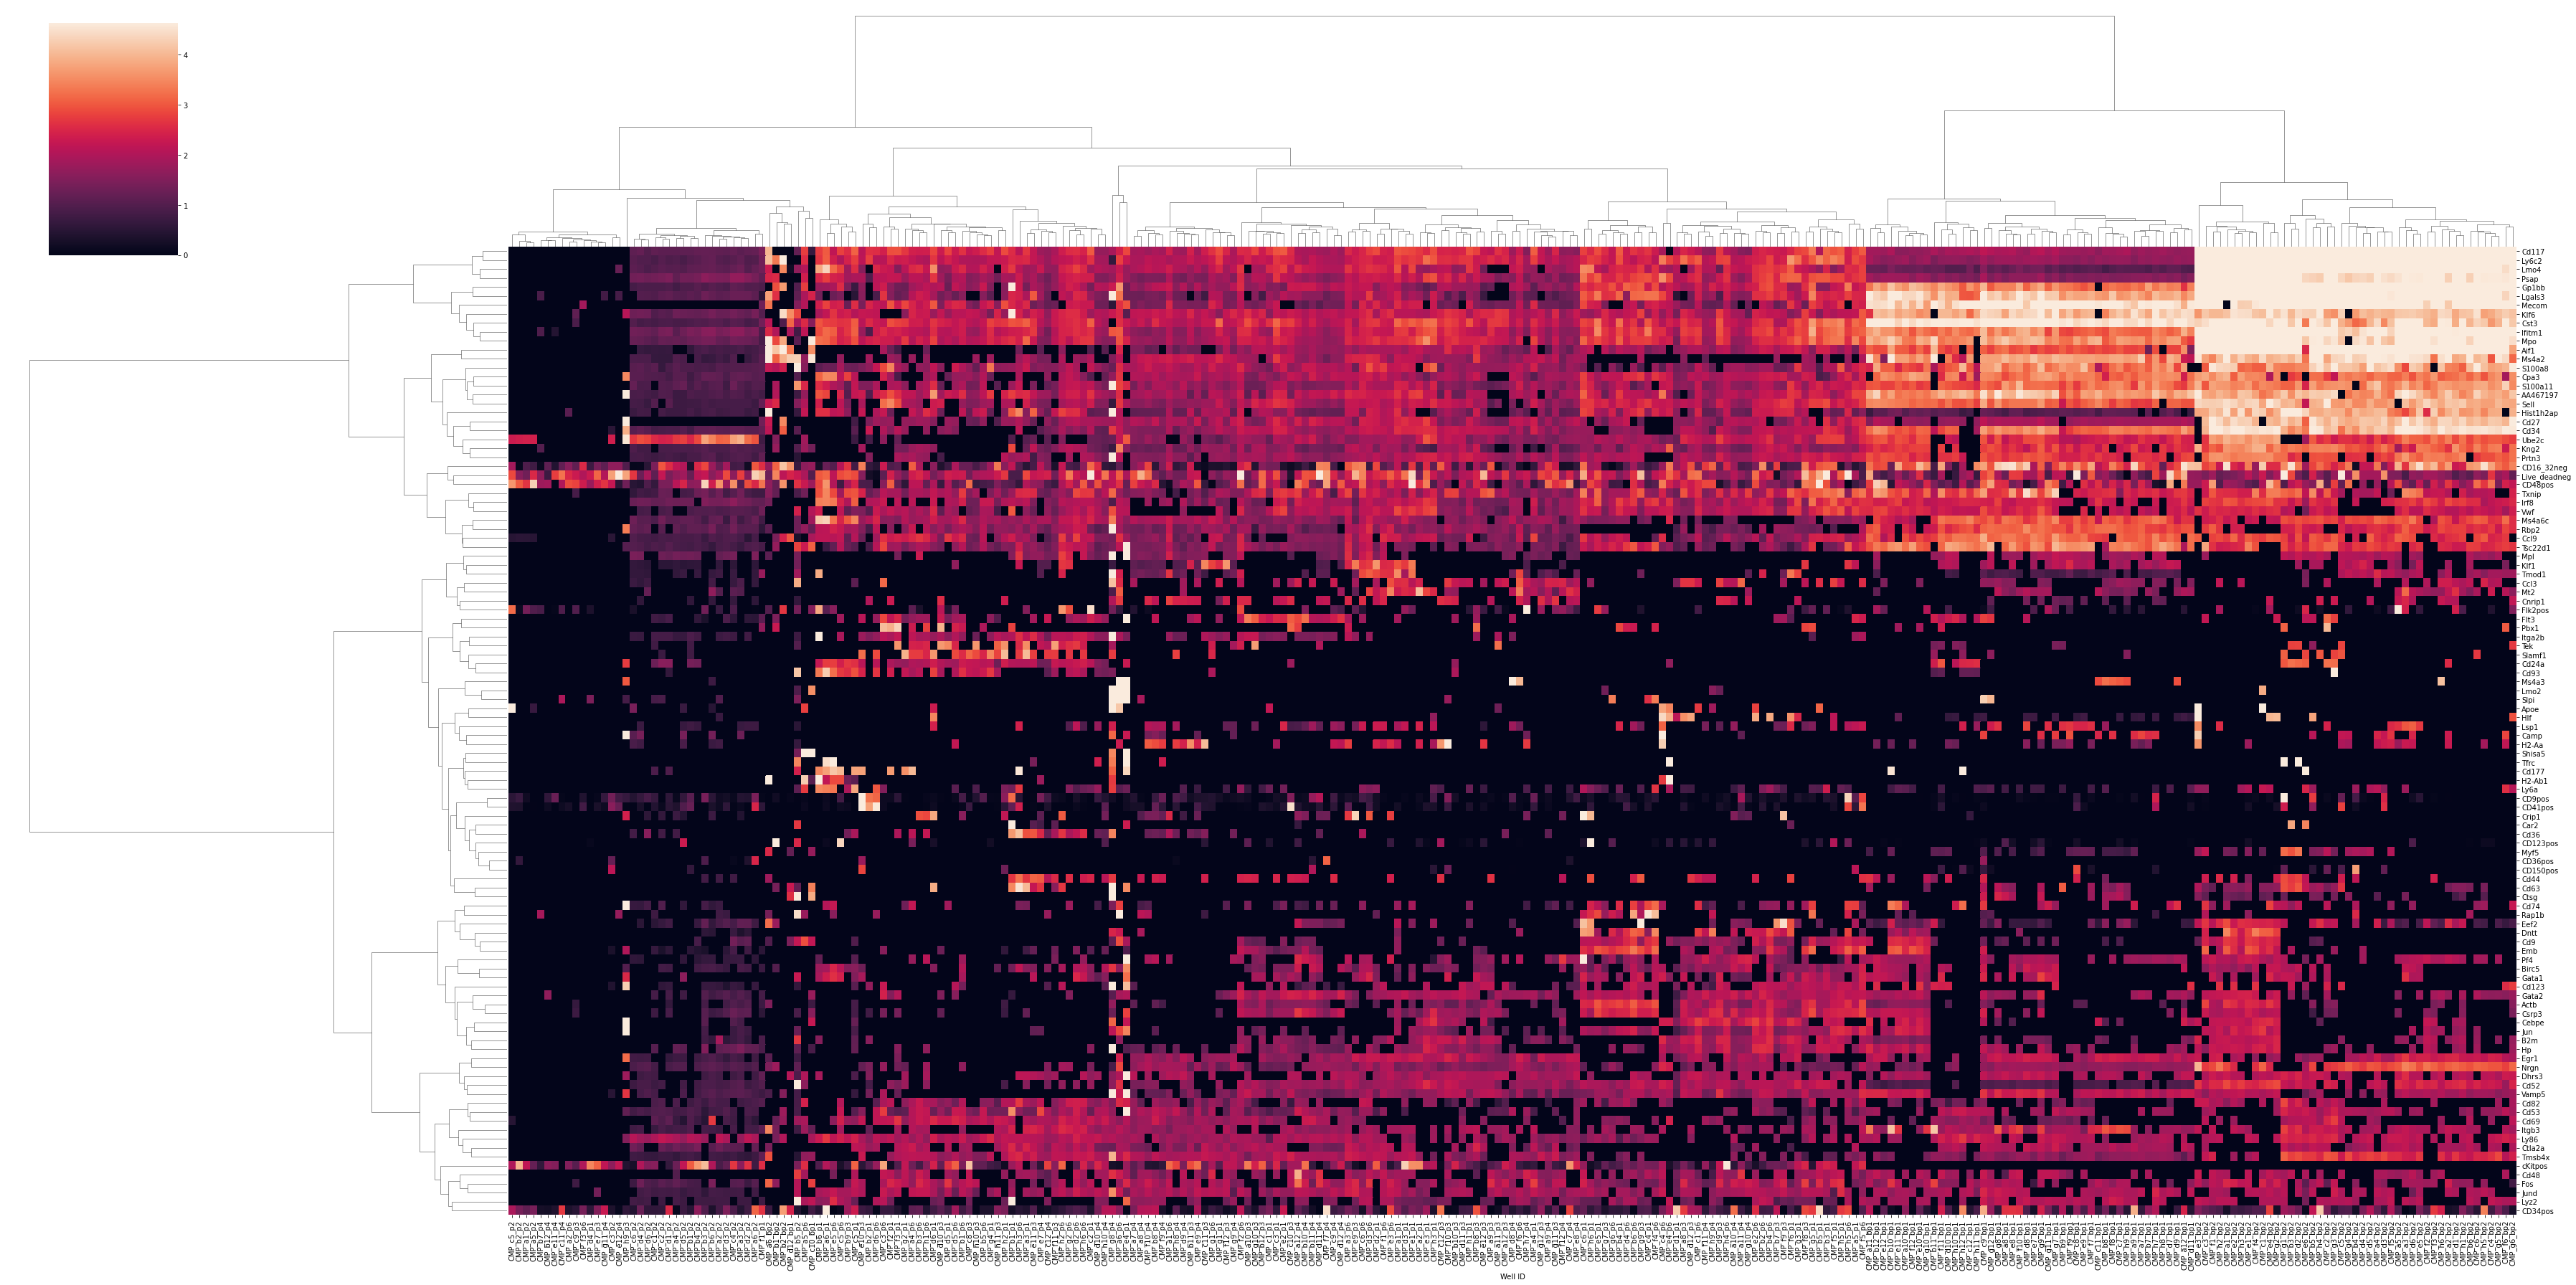

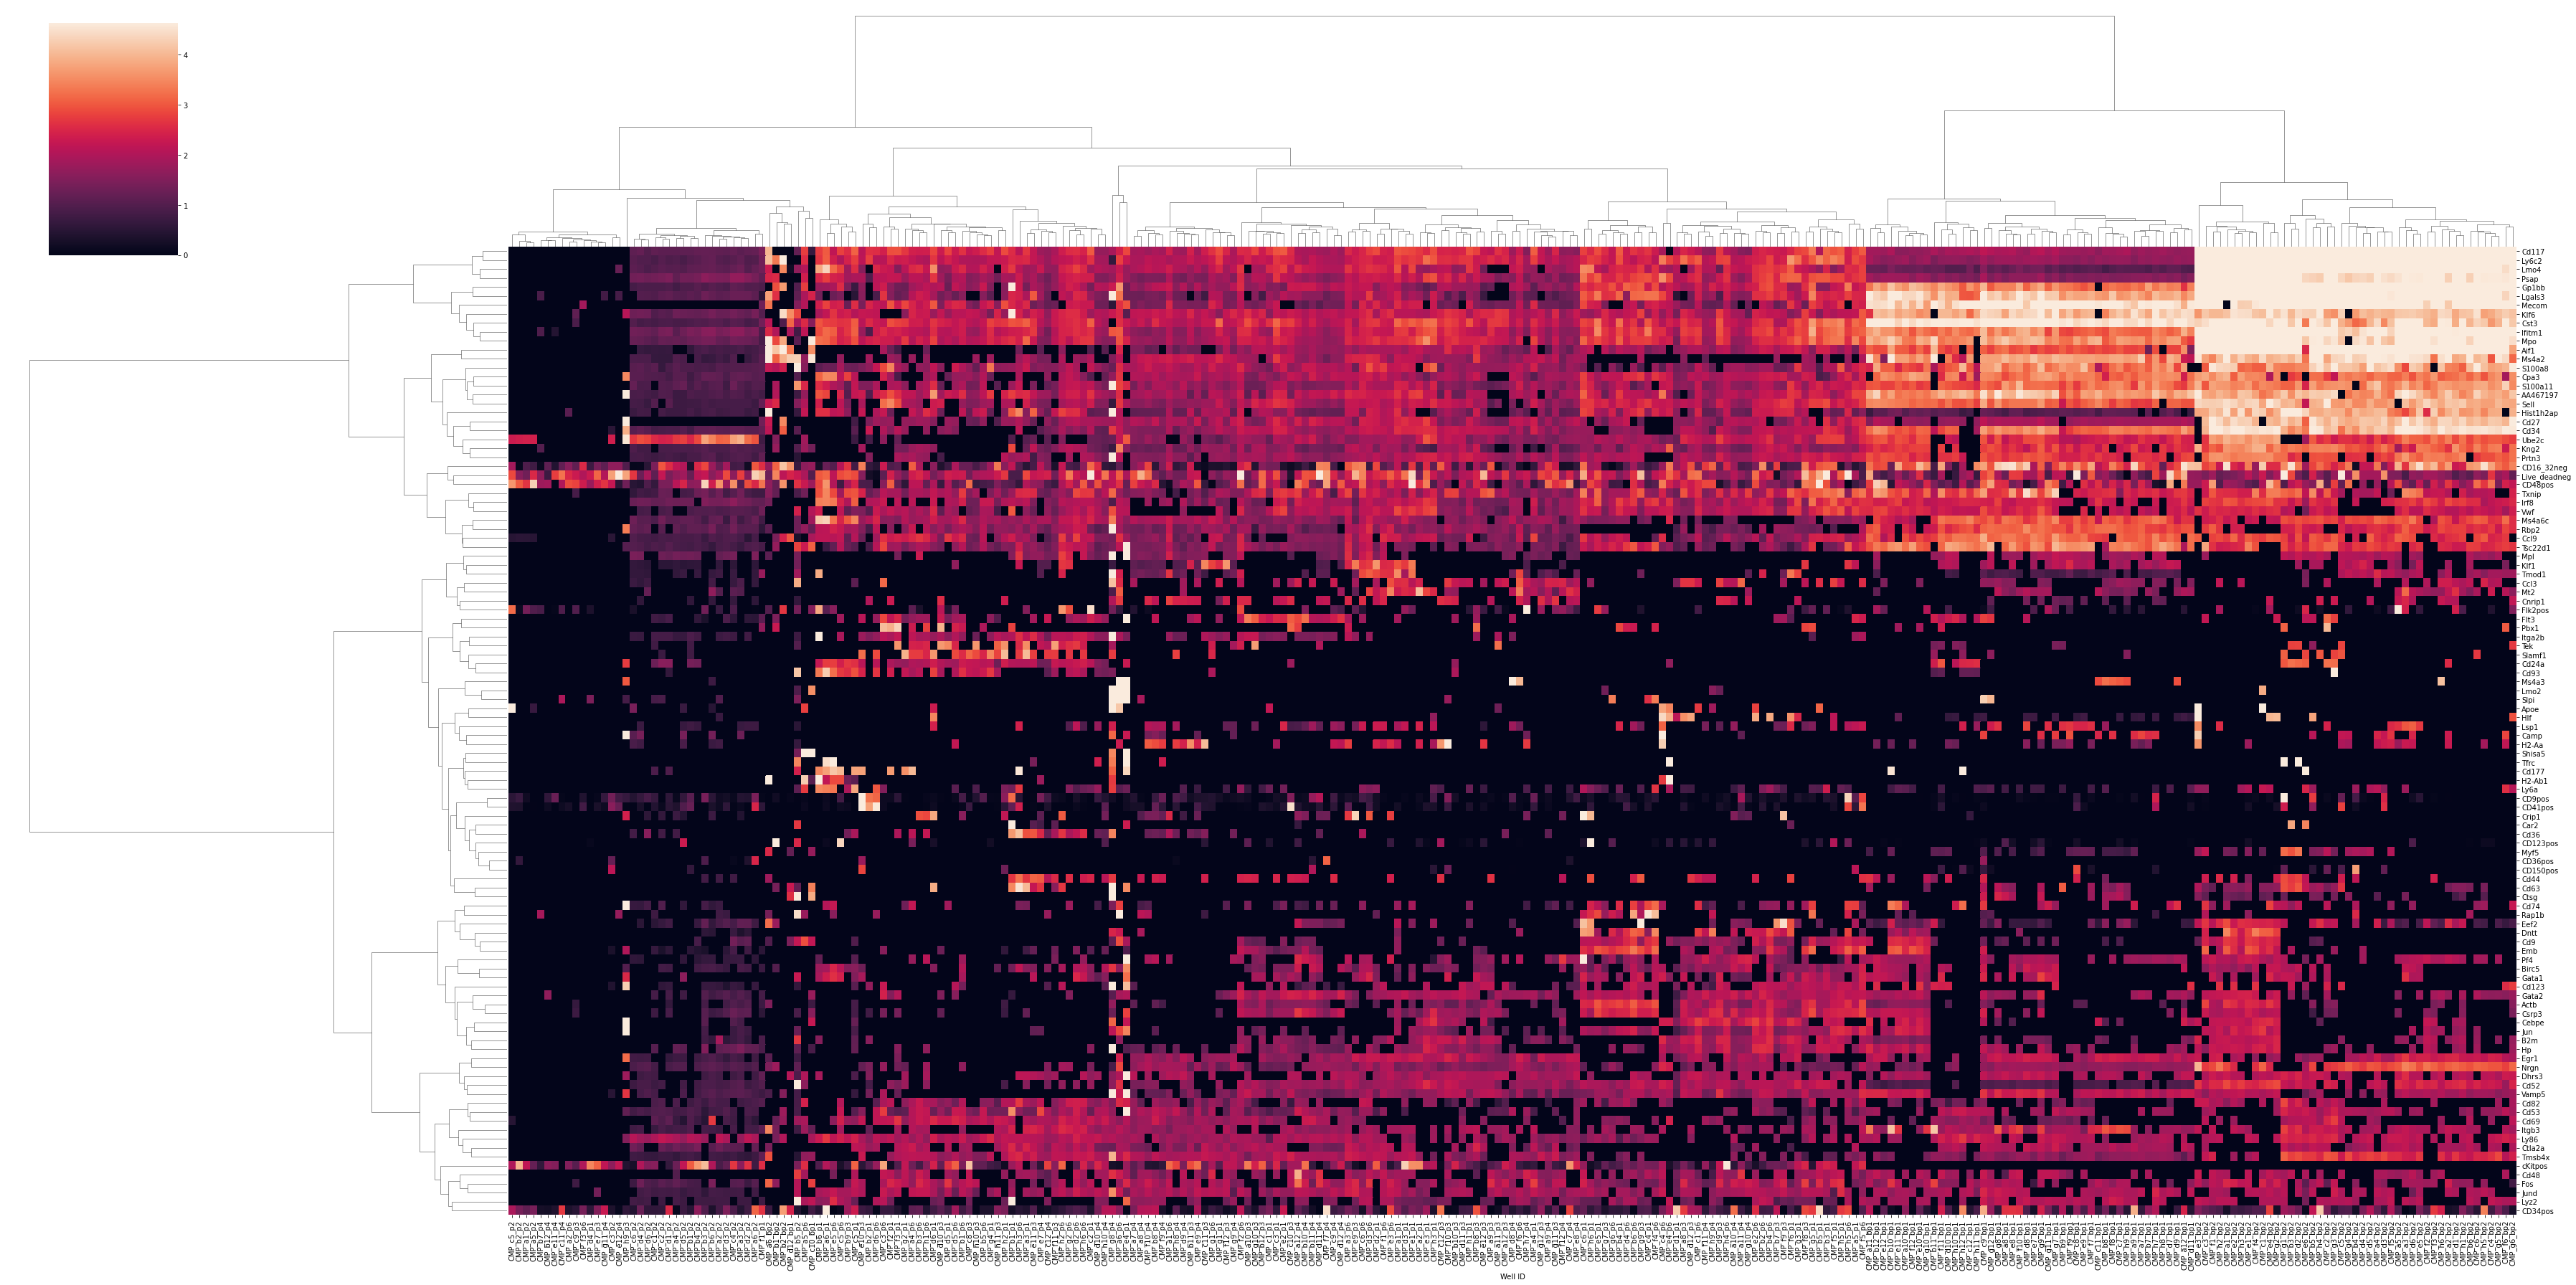

In [31]:
hm_rows = sns.clustermap(cmp_integrated.transpose(), figsize=(50,25), method = 'ward', robust = True, xticklabels = True, yticklabels = True).dendrogram_row.reordered_ind
hm_cols = sns.clustermap(cmp_integrated.transpose(), figsize=(50,25), method = 'ward', robust = True, xticklabels = True, yticklabels = True).dendrogram_col.reordered_ind

<a id='FlowHeatmaps'></a>
## Create heatmaps from flow cytometery data

### Pool cytometry and probe data and create heatmaps

In [24]:
flow_data_xl = pd.ExcelFile("BioMark_MFI.xlsx")

In [25]:
flow_data_xl.sheet_names

['090618_LSK_bp1and2',
 '090618_CMP_bp1and2',
 '121218_LSK_p2and4',
 '121218_CMP_p2and4',
 '010319_MEP_p1and3',
 '010319_CMP_p1and3',
 '011019_LSK_p5',
 '012319_LSK_p9and11',
 '012319_MEP_p9and11',
 '020619_LSK_p8and10',
 '020619_MEP_p8and10',
 '020119_MEP_p6and7',
 '020119_CMP_p6and7']

In [26]:
cmp_indexStats = pd.DataFrame([])
flow_data_cls = flow_data_xl.parse(i, index_col=0)
flow_data_cls = flow_normalization(flow_data_cls)
cmp_indexStats = cmp_indexStats.append(flow_data_cls)

### Cluster flow data according to continuous MFI values
Use FlowJo to define gates for each fluorophore <br>
Set cells negative for fluorophore as "N/A" <br>
Normalize and set SD to 1<br>
Replace N/As as 0

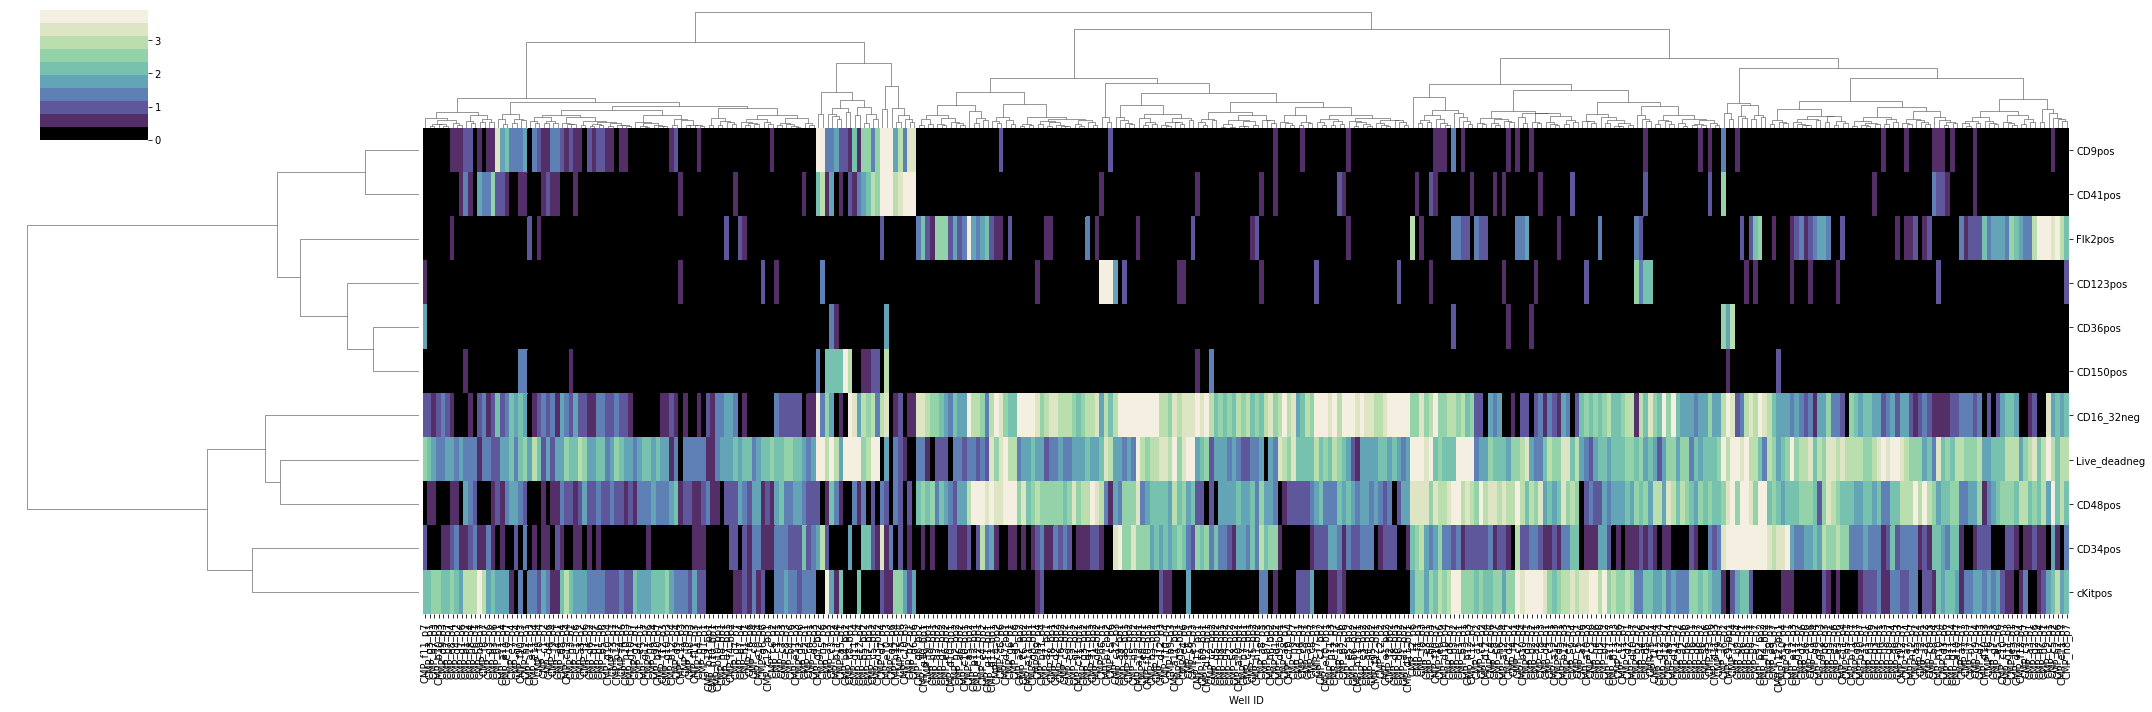

In [21]:
cmpclusetering = sns.clustermap(cmp_indexStats.transpose(), figsize=(30, 10), method = 'ward', yticklabels = True, xticklabels = True, robust = True, cmap = heatmap_colors)
cmpclusetering.savefig("CMP_fluorophoreClustering_norm.png", dpi=400)

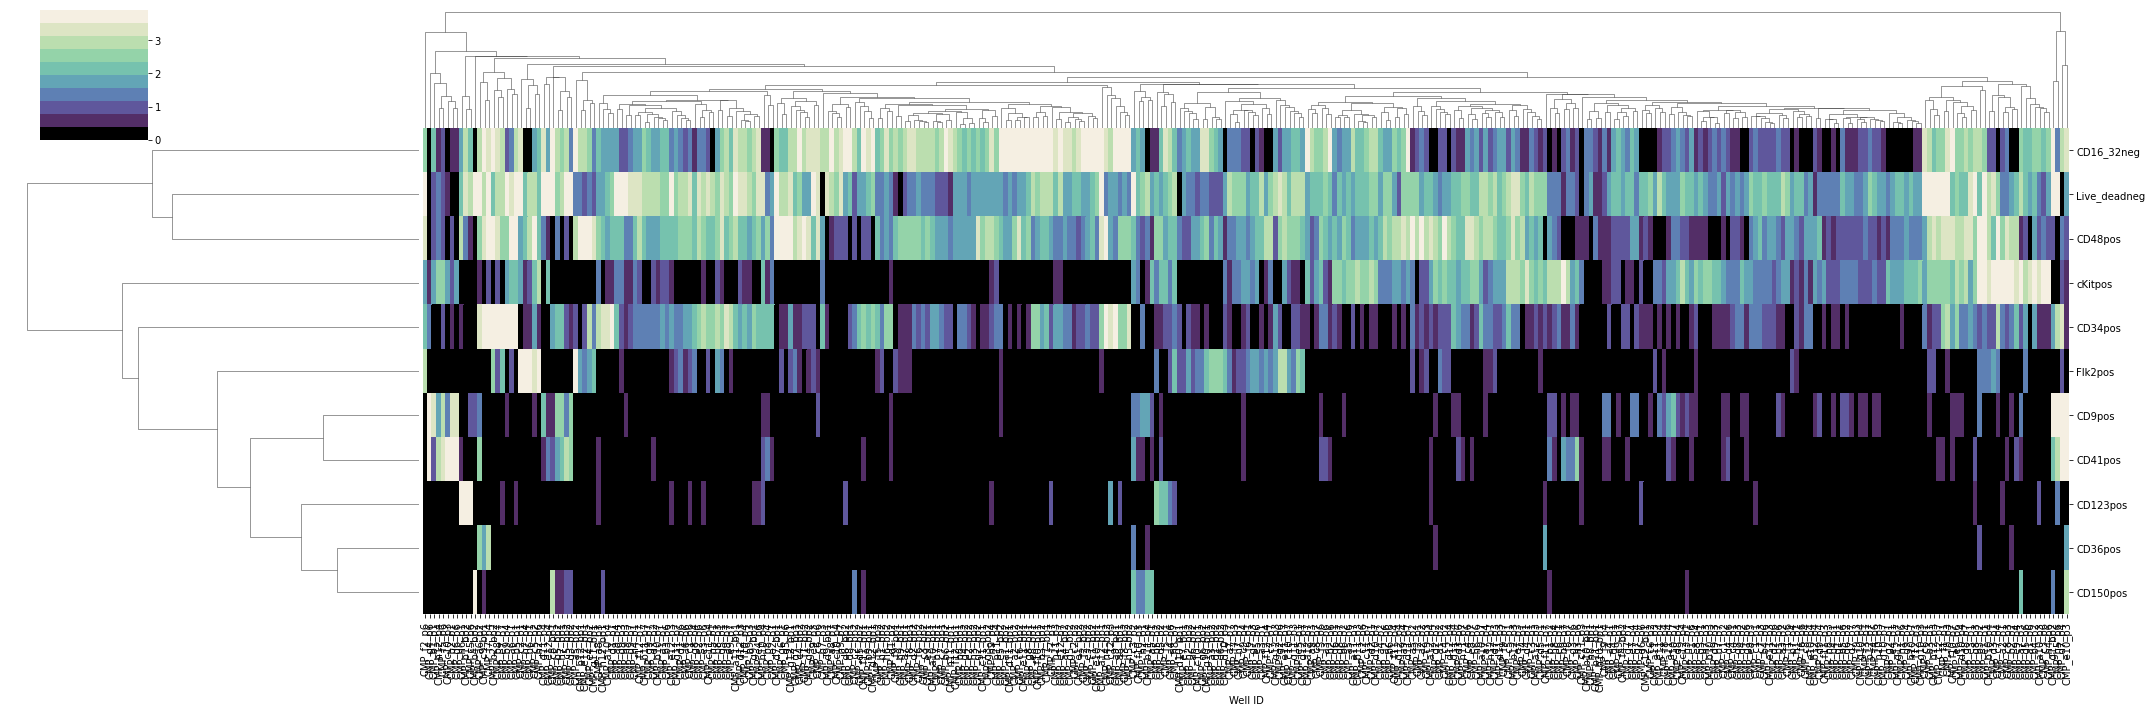

In [22]:
cmpclusetering = sns.clustermap(cmp_indexStats.transpose(), figsize=(30, 10), method = 'average', yticklabels = True, xticklabels = True, robust = True, cmap = heatmap_colors)
cmpclusetering.savefig("CMP_fluorophoreClustering_avg_norm.png", dpi=400)

### Bin flow data according to mean

Set bin values as:
>x = 0 <br>
>0 < x <= x.mean() <br>
>x.mean() < x <= x.mean()+(2)(x.std())<br>
>x.mean()+(2)(x.std()) < x

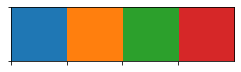

In [23]:
current_palette = sns.color_palette(n_colors=4)
sns.palplot(current_palette)

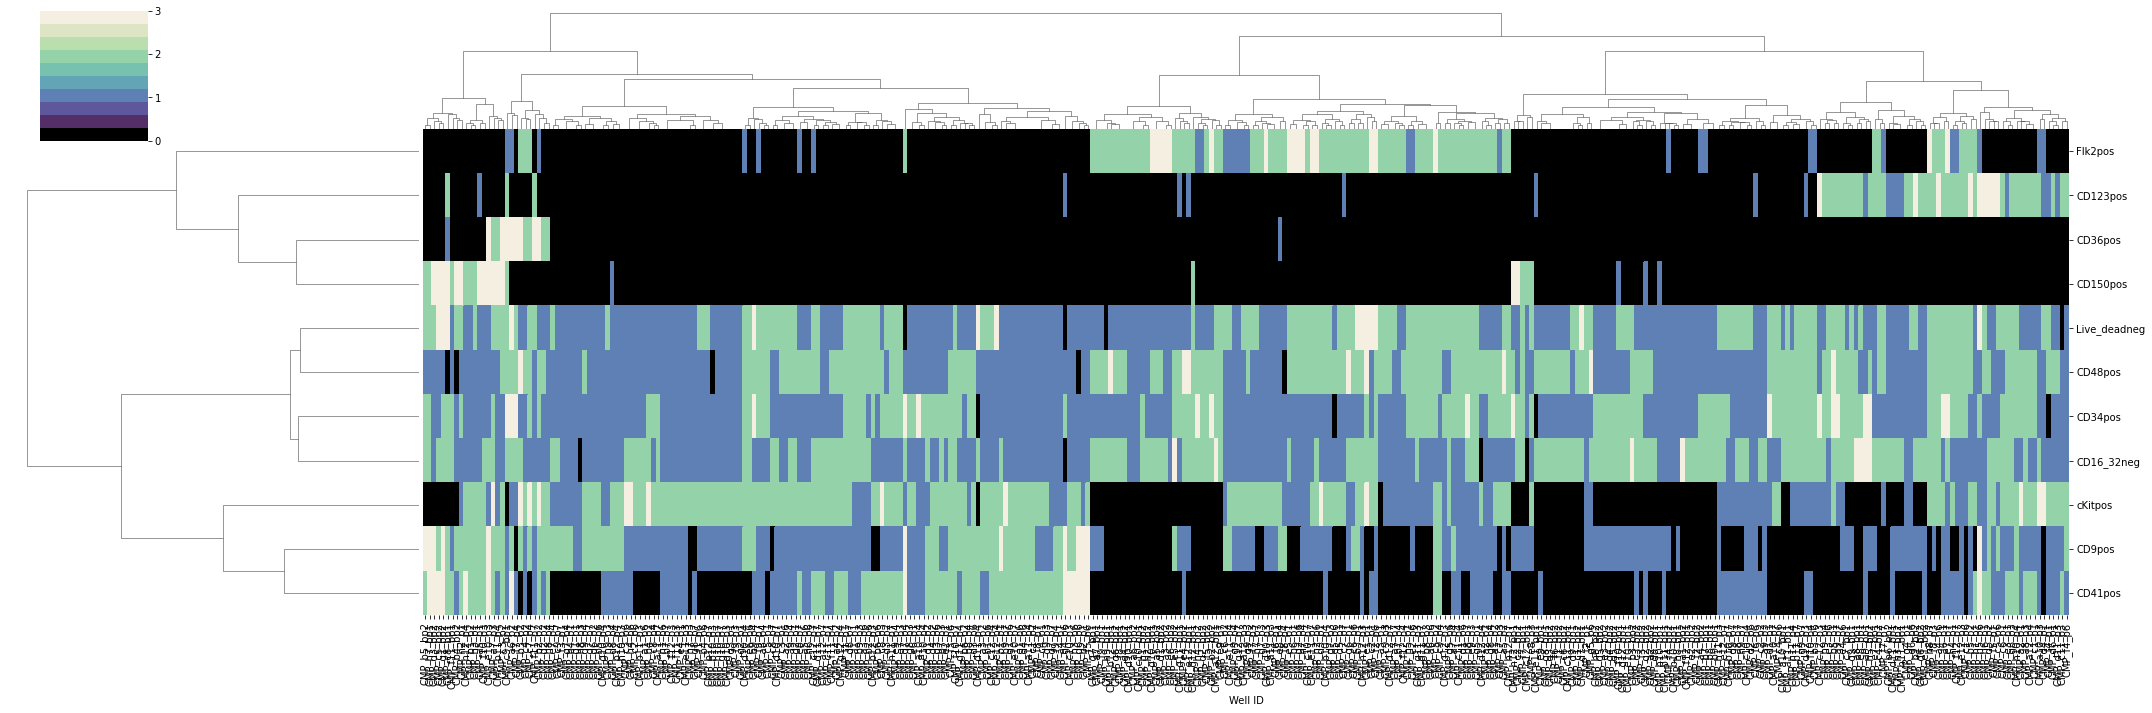

In [24]:
cmp_binned = pd.DataFrame()
cols = cmp_indexStats.columns
cmp_binned[cols]  = cmp_indexStats[cols].apply(binning_flow)
cmp_binned = cmp_binned.astype(float)
# cmpcluster = sns.clustermap(cmp_binned.transpose(), figsize=(30,10), method = 'ward', yticklabels = True, xticklabels = False, cmap = current_palette, row_cluster=False, cbar_kws = {"ticks": [0, 1, 2, 3]})
cmpcluster = sns.clustermap(cmp_binned.transpose(), figsize=(30, 10), method = 'ward', yticklabels = True, xticklabels = True, cbar_kws = {"ticks": [0, 1, 2, 3]}, cmap = heatmap_colors)
# cmpcluster.savefig("CMP_fluorophoreClustering-Binned.png", dpi = 400)

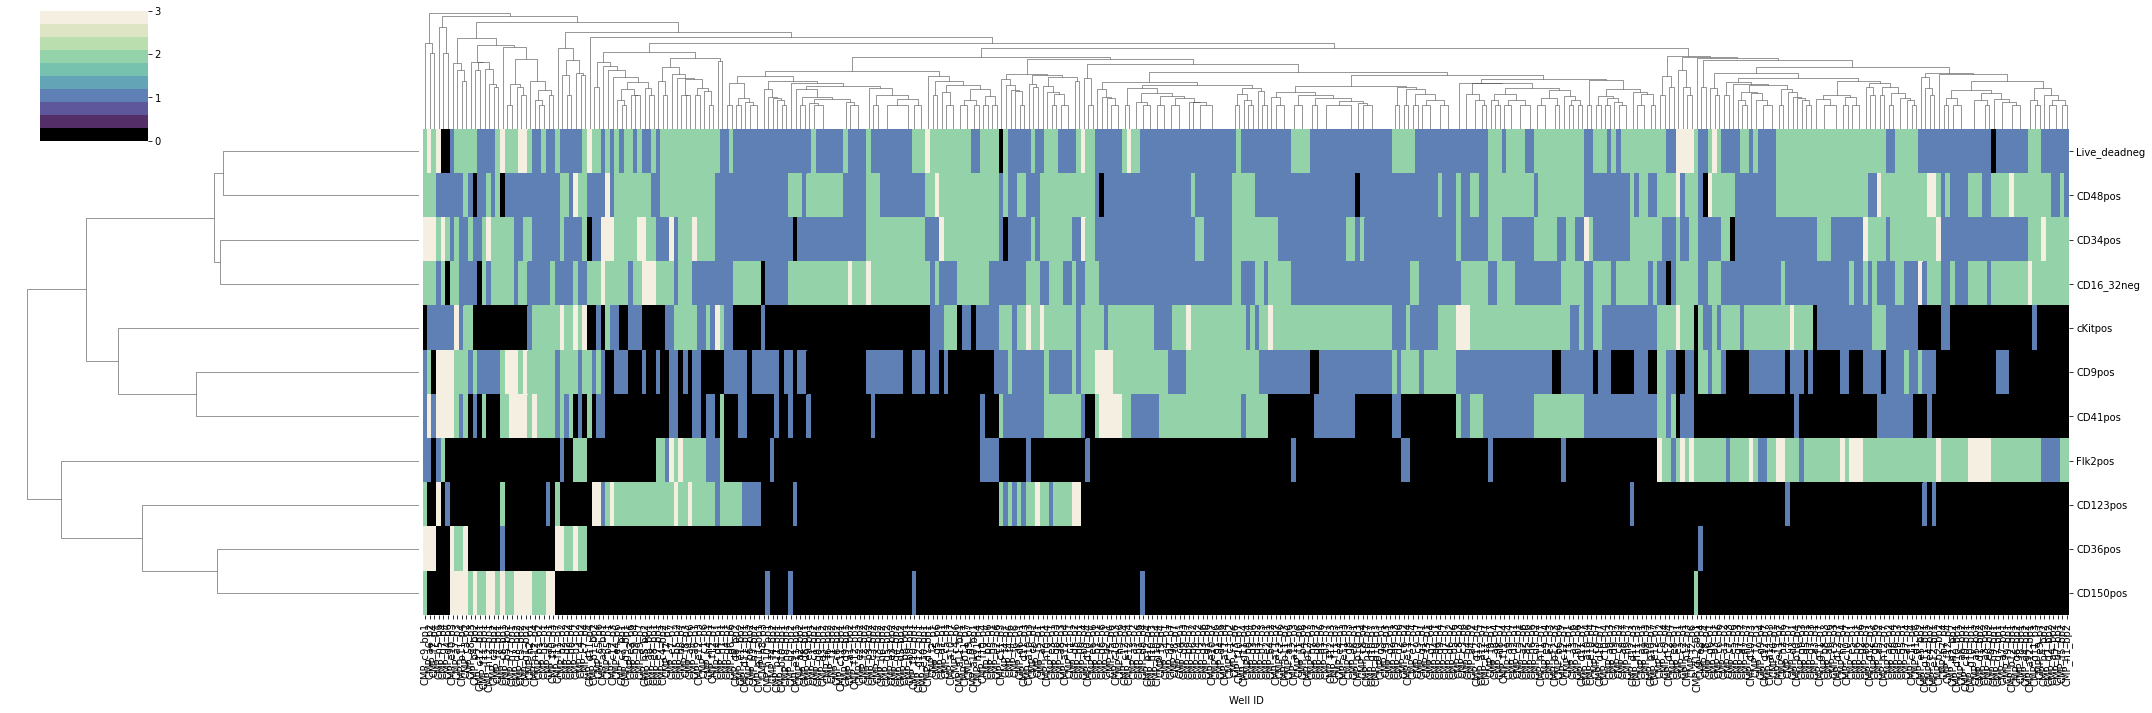

In [25]:
cmp_binned = pd.DataFrame()
cols = cmp_indexStats.columns
cmp_binned[cols]  = cmp_indexStats[cols].apply(binning_flow)
cmp_binned = cmp_binned.astype(float)
# cmpcluster = sns.clustermap(cmp_binned.transpose(), figsize=(30,10), method = 'ward', yticklabels = True, xticklabels = False, cmap = current_palette, row_cluster=False, cbar_kws = {"ticks": [0, 1, 2, 3]})
cmpcluster = sns.clustermap(cmp_binned.transpose(), figsize=(30, 10), method = 'average', yticklabels = True, xticklabels = True, cbar_kws = {"ticks": [0, 1, 2, 3]}, cmap = heatmap_colors)
# cmpcluster.savefig("CMP_fluorophoreClustering-Binned_avg.png", dpi = 400)

### Integrate QPCR biomark data with continuous MFI flow values

In [26]:
# Integrate CMP biomark and flow data
cmp_integrated = pd.DataFrame([])
cmp_integrated = join_biomarkData(cmp_integrated, cmpbiomark.copy(), cmp_indexStats.copy())
print("\nCMP integrated dataframe ", cmp_integrated.shape)



CMP integrated dataframe  (170, 108)


### Integrate QPCR biomark data with binned MFI flow values

In [32]:
# Integrate CMP biomark and flow data
cmp_integrated_binned = pd.DataFrame([])
cmp_integrated_binned = join_biomarkData(cmp_integrated, cmpbiomark.copy(), cmp_binned.copy())
print("\nCMP integrated dataframe ", cmp_integrated.shape)


CMP integrated dataframe  (170, 108)


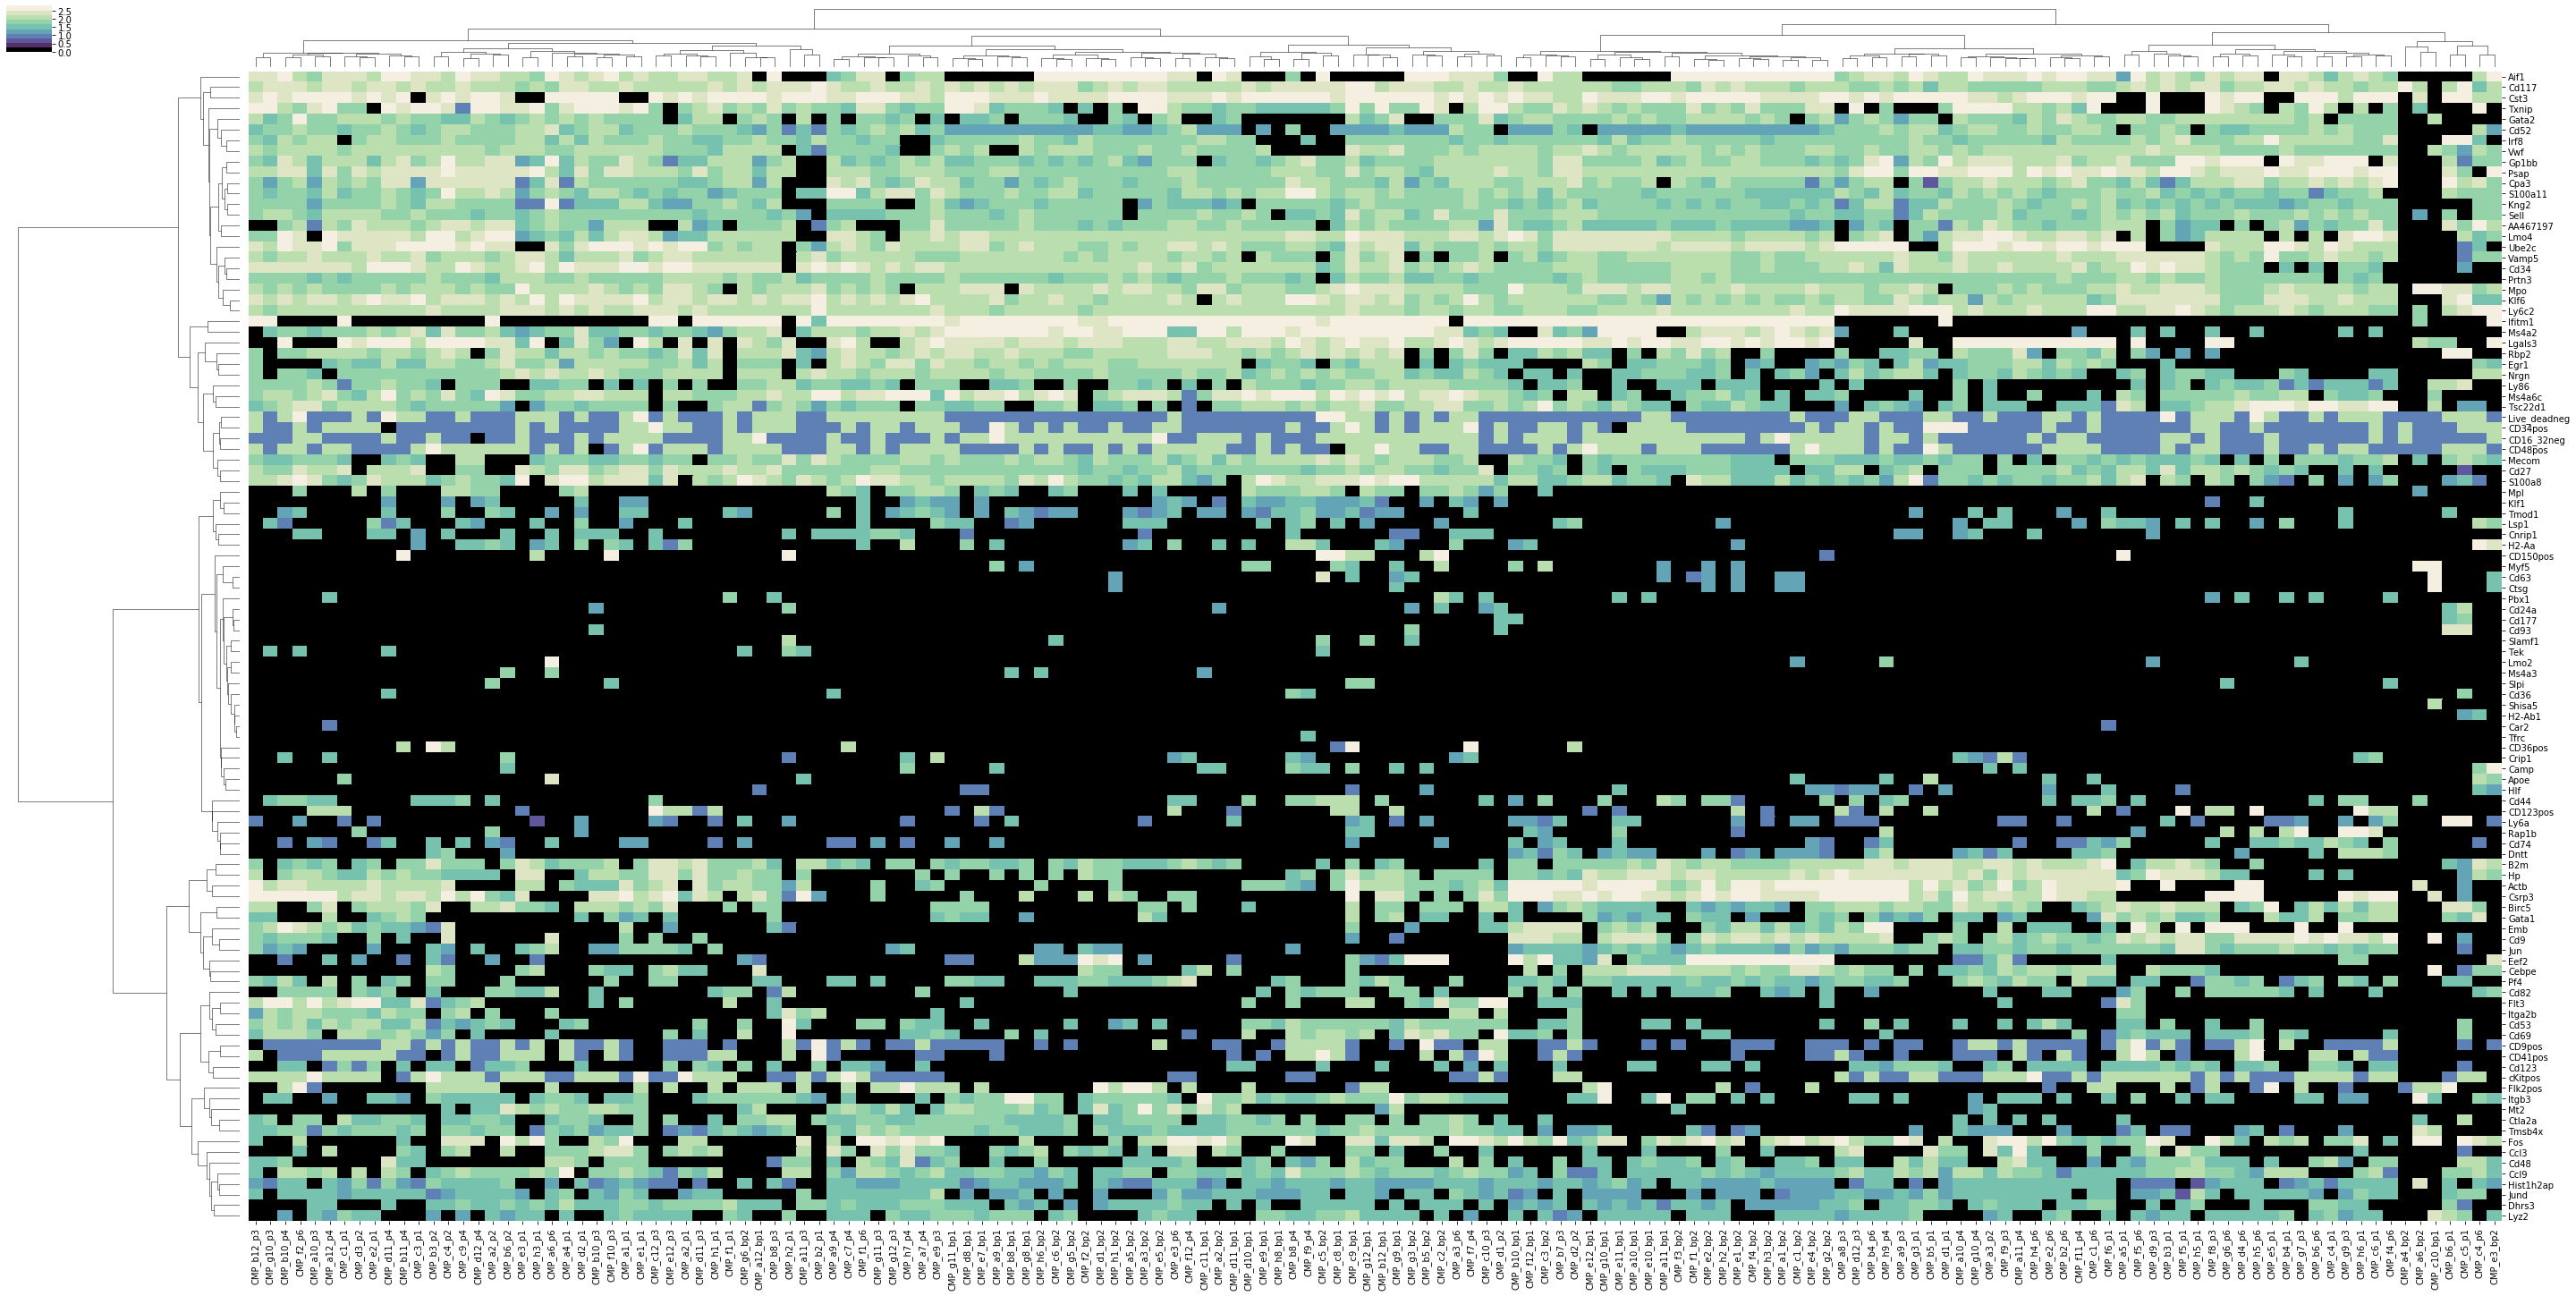

In [51]:
sns.clustermap(cmp_integrated_binned.transpose(), figsize=(50,25), method = 'ward', robust = True, xticklabels = True, yticklabels = True, cmap = heatmap_colors)
savefig("CMP_integrated_binned_norm.png", dpi = 400)

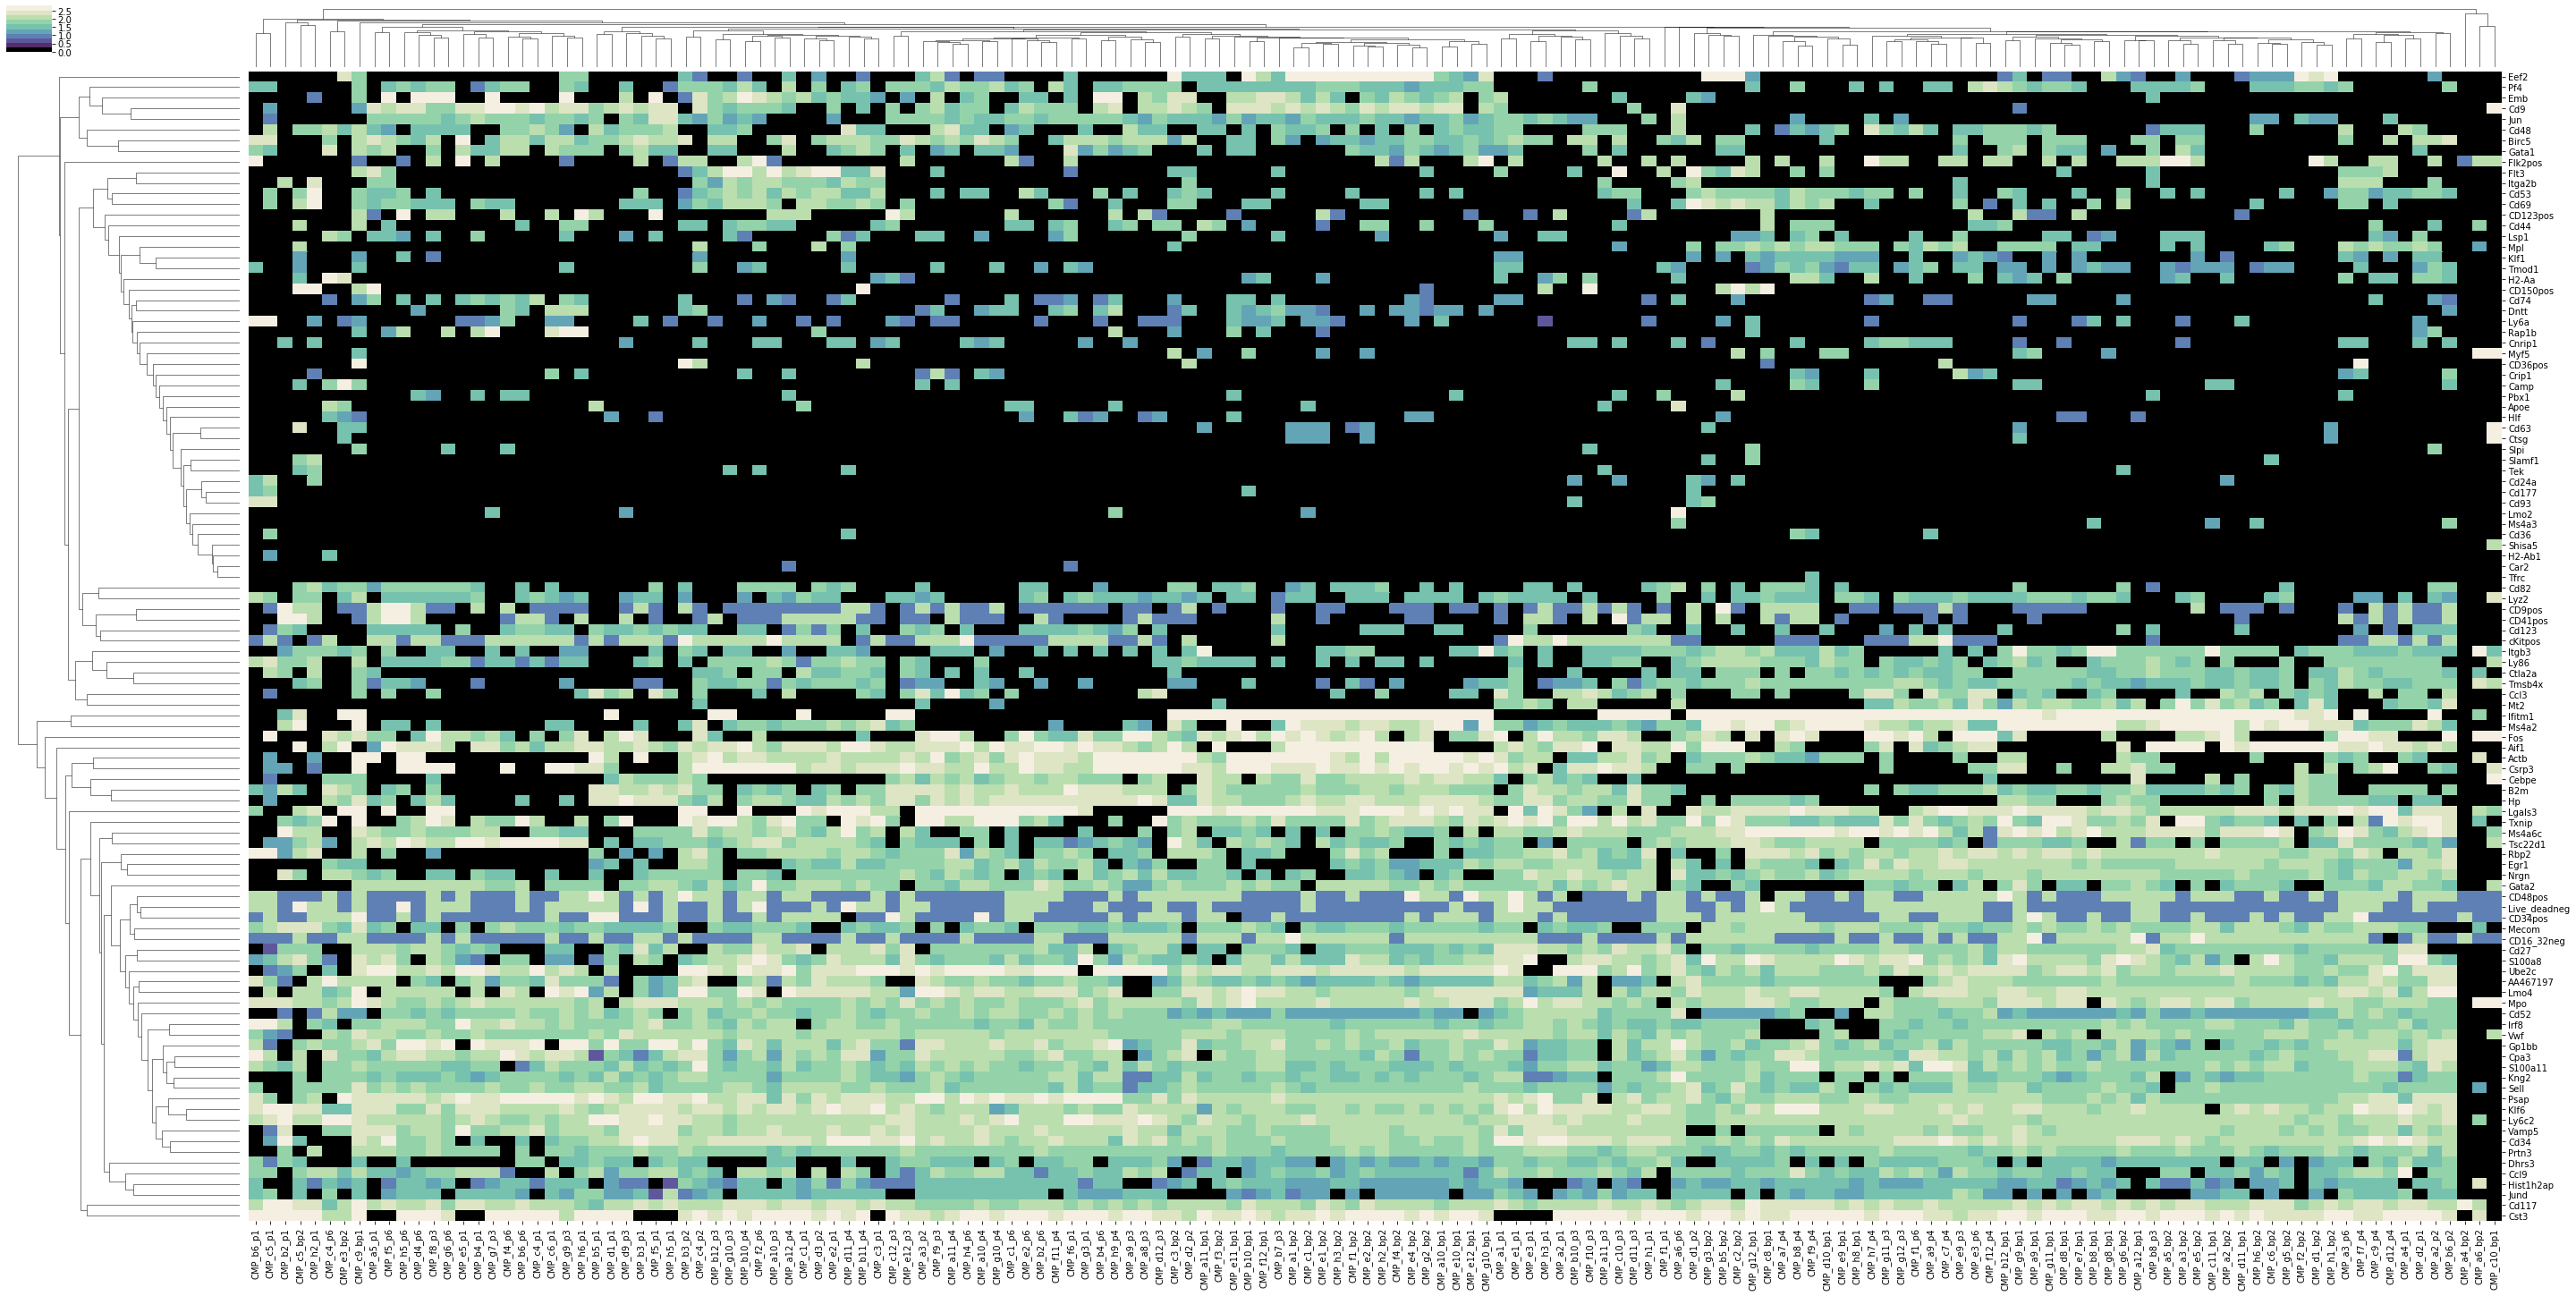

In [52]:
sns.clustermap(cmp_integrated_binned.transpose(), figsize=(50,25), method = 'average', robust = True, xticklabels = True, yticklabels = True, cmap = heatmap_colors)
savefig("CMP_integrated_binned_avg_norm.png", dpi = 400)

Can color individual leaves to show which markers correspond with which celltypes
https://python-graph-gallery.com/405-dendrogram-with-heatmap-and-coloured-leaves/

Seaborn color pallets @ http://jose-coto.com/styling-with-seaborn. 

In [50]:
roi = ['Irf8', 'Mpo', 'Gp1bb', 'Pf4', 'Vwf', 'Itga2b', 'Gata2', 'Gata1', 'Klf1', 'Birc5']
foi = ['CD16_32neg', 'Live_deadneg', 'CD48pos', 'Flk2pos', 'CD9pos', 'CD41pos', 'CD123pos', 'CD36pos', 'CD150pos', 'cKitpos', 'CD34pos']

In [43]:
filteredDF = cmp_integrated.transpose()

In [44]:
col_order = []
for pos in hm_cols:
    newcol = cmp_integrated.transpose().columns[pos]
    col_order.append(newcol)

In [45]:
filteredDF = filteredDF.loc[filteredDF.index.isin(roi)]

In [46]:
filteredDF.index = pd.CategoricalIndex(filteredDF.index, roi)
filteredDF = filteredDF[col_order]
filteredDF = filteredDF.sort_index()

In [47]:
filteredDF.head()

Well ID,CMP_c5_p2,CMP_b2_p2,CMP_a1_p2,CMP_a5_p2,CMP_b7_p4,CMP_b12_p4,CMP_e11_p4,CMP_c11_p4,CMP_a2_p6,CMP_c9_p3,...,CMP_a2_bp2,CMP_d1_bp2,CMP_h1_bp2,CMP_b6_bp2,CMP_c6_bp2,CMP_h5_bp2,CMP_c4_bp2,CMP_g5_bp2,CMP_f6_bp2,CMP_g6_bp2
Irf8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.886626,2.691114,2.761159,2.569756,2.574034,1.941430,2.188376,2.291847,2.354352,2.513654
Mpo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.170122,5.255064,4.929507,4.340445,4.889085,4.812722,4.624620,4.634856,4.671266,4.468066
Gp1bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.630483,5.977578,6.721168,4.659190,5.319993,5.957882,5.809264,6.058636,5.641626,6.270852
Pf4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.177231,2.056484,1.903865,0.000000,1.891294,1.861150,0.000000,1.858547,0.000000,0.000000
Vwf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.078868,2.065036,2.269309,2.078605,2.329879,2.229543,2.104586,2.251838,1.852005,2.372934


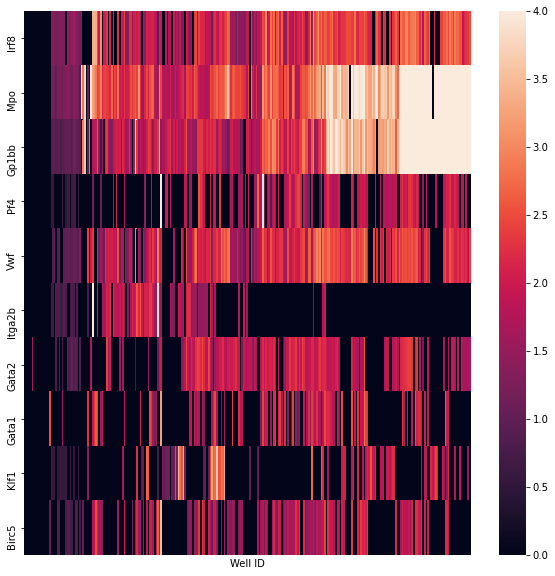

In [41]:
plt.figure(figsize=(10,10))
# sns.heatmap(filteredDF[filteredDF.index.isin(roi)], xticklabels = False, yticklabels = True, vmin = 0, vmax = 5)# for NHGRI symposium
sns.heatmap(filteredDF[filteredDF.index.isin(roi)], xticklabels = False, yticklabels = True, vmin = 0, vmax = 4) # for publication

In [48]:
filteredDF = cmp_integrated.transpose()

In [49]:
col_order = []
for pos in hm_cols:
    newcol = cmp_integrated.transpose().columns[pos]
    col_order.append(newcol)

In [51]:
filteredDF = filteredDF.loc[filteredDF.index.isin(foi)]

In [52]:
filteredDF.index = pd.CategoricalIndex(filteredDF.index, foi)
filteredDF = filteredDF[col_order]
filteredDF = filteredDF.sort_index()

In [53]:
filteredDF.head()

Well ID,CMP_c5_p2,CMP_b2_p2,CMP_a1_p2,CMP_a5_p2,CMP_b7_p4,CMP_b12_p4,CMP_e11_p4,CMP_c11_p4,CMP_a2_p6,CMP_c9_p3,...,CMP_a2_bp2,CMP_d1_bp2,CMP_h1_bp2,CMP_b6_bp2,CMP_c6_bp2,CMP_h5_bp2,CMP_c4_bp2,CMP_g5_bp2,CMP_f6_bp2,CMP_g6_bp2
CD16_32neg,1.889854,0.108456,0.954417,0.764618,0.109812,1.130658,0.425692,1.164551,1.592554,1.150919,...,3.728039,2.284451,2.415835,3.636070,3.760886,4.498282,3.803586,3.273120,3.044839,3.461985
Live_deadneg,2.865467,1.588129,1.334477,2.534385,1.670366,0.730518,2.762939,3.262767,2.525413,2.305262,...,1.518779,0.994969,1.292650,1.081101,1.683483,1.455328,2.654151,1.718583,1.930537,1.205951
CD48pos,3.645029,3.043767,2.666702,4.312130,1.796027,1.876813,0.066029,2.024953,2.904333,2.825615,...,2.692375,2.151980,1.542053,1.891455,3.225206,2.692375,3.311465,1.431938,2.411631,2.193437
Flk2pos,3.204009,0.156660,1.375600,0.963563,0.873431,0.000000,0.057943,0.946395,0.000000,0.994161,...,0.000000,2.403027,0.938205,0.000000,0.000000,0.000000,0.409646,0.000000,0.000000,1.492003
CD9pos,0.529362,0.701207,0.197153,0.013456,0.000000,0.590841,1.256247,0.063331,0.006466,0.000000,...,0.020818,0.000000,0.000000,0.000000,0.000000,0.001004,0.000000,0.008234,0.000000,0.000000


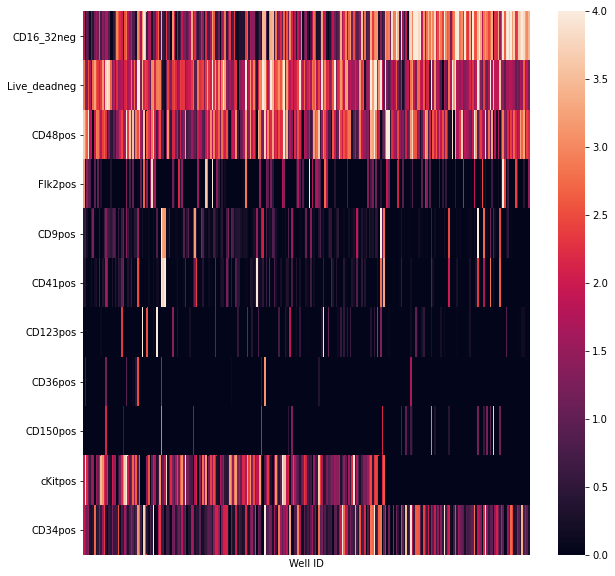

In [57]:
plt.figure(figsize=(10,10))
# sns.heatmap(goi[goi.index.isin(roi)], xticklabels = False, yticklabels = True, vmin = 0, vmax = 5)# for NHGRI symposium
sns.heatmap(filteredDF[filteredDF.index.isin(foi)], xticklabels = False, yticklabels = True, vmin = 0, vmax = 4) # for publication

### Integrate QPCR biomark data with binned MFI flow values

In [45]:
# Integrate CMP biomark and flow data
cmp_integrated_binned = pd.DataFrame([])
cmp_integrated_binned = join_biomarkData_v2(cmp_integrated_binned, cmpbiomarkT.copy(), cmp_binned.copy())
print("\nCMP integrated dataframe ", cmp_integrated.shape)


CMP integrated dataframe  (281, 108)


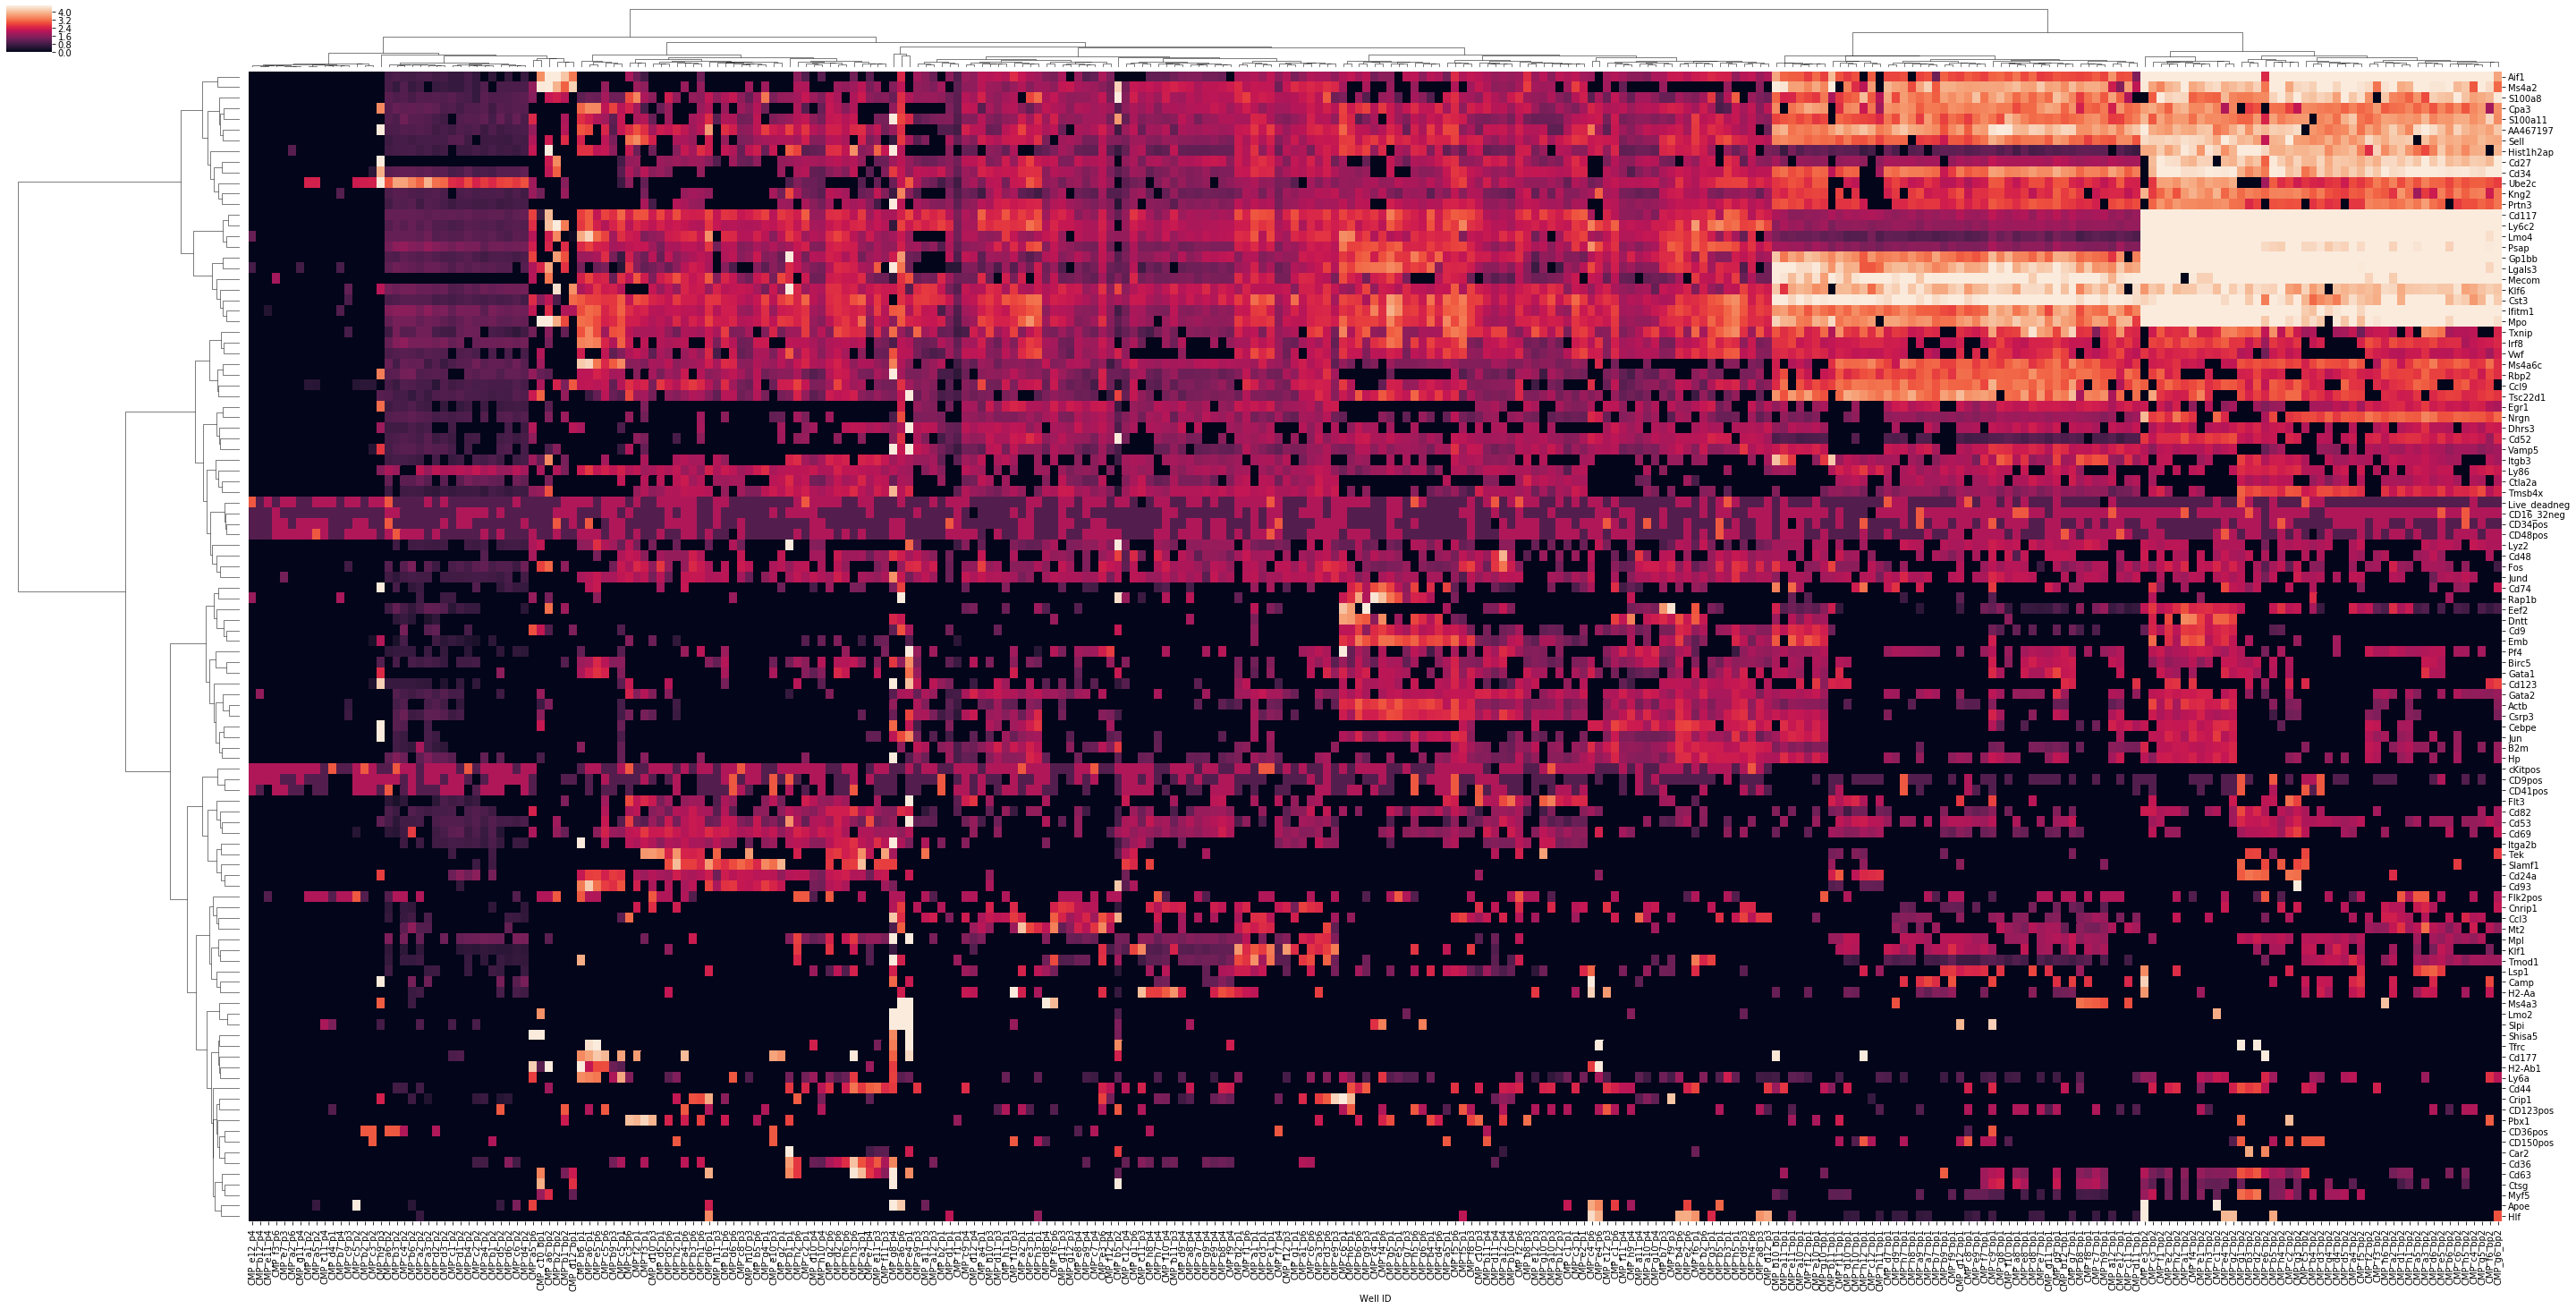

In [86]:
sns.clustermap(cmp_integrated_binned.transpose(), figsize=(50,25), method = 'ward', robust = True, xticklabels = True, yticklabels = True)
savefig("CMP_integrated_binnedT_norm.png", dpi = 400)

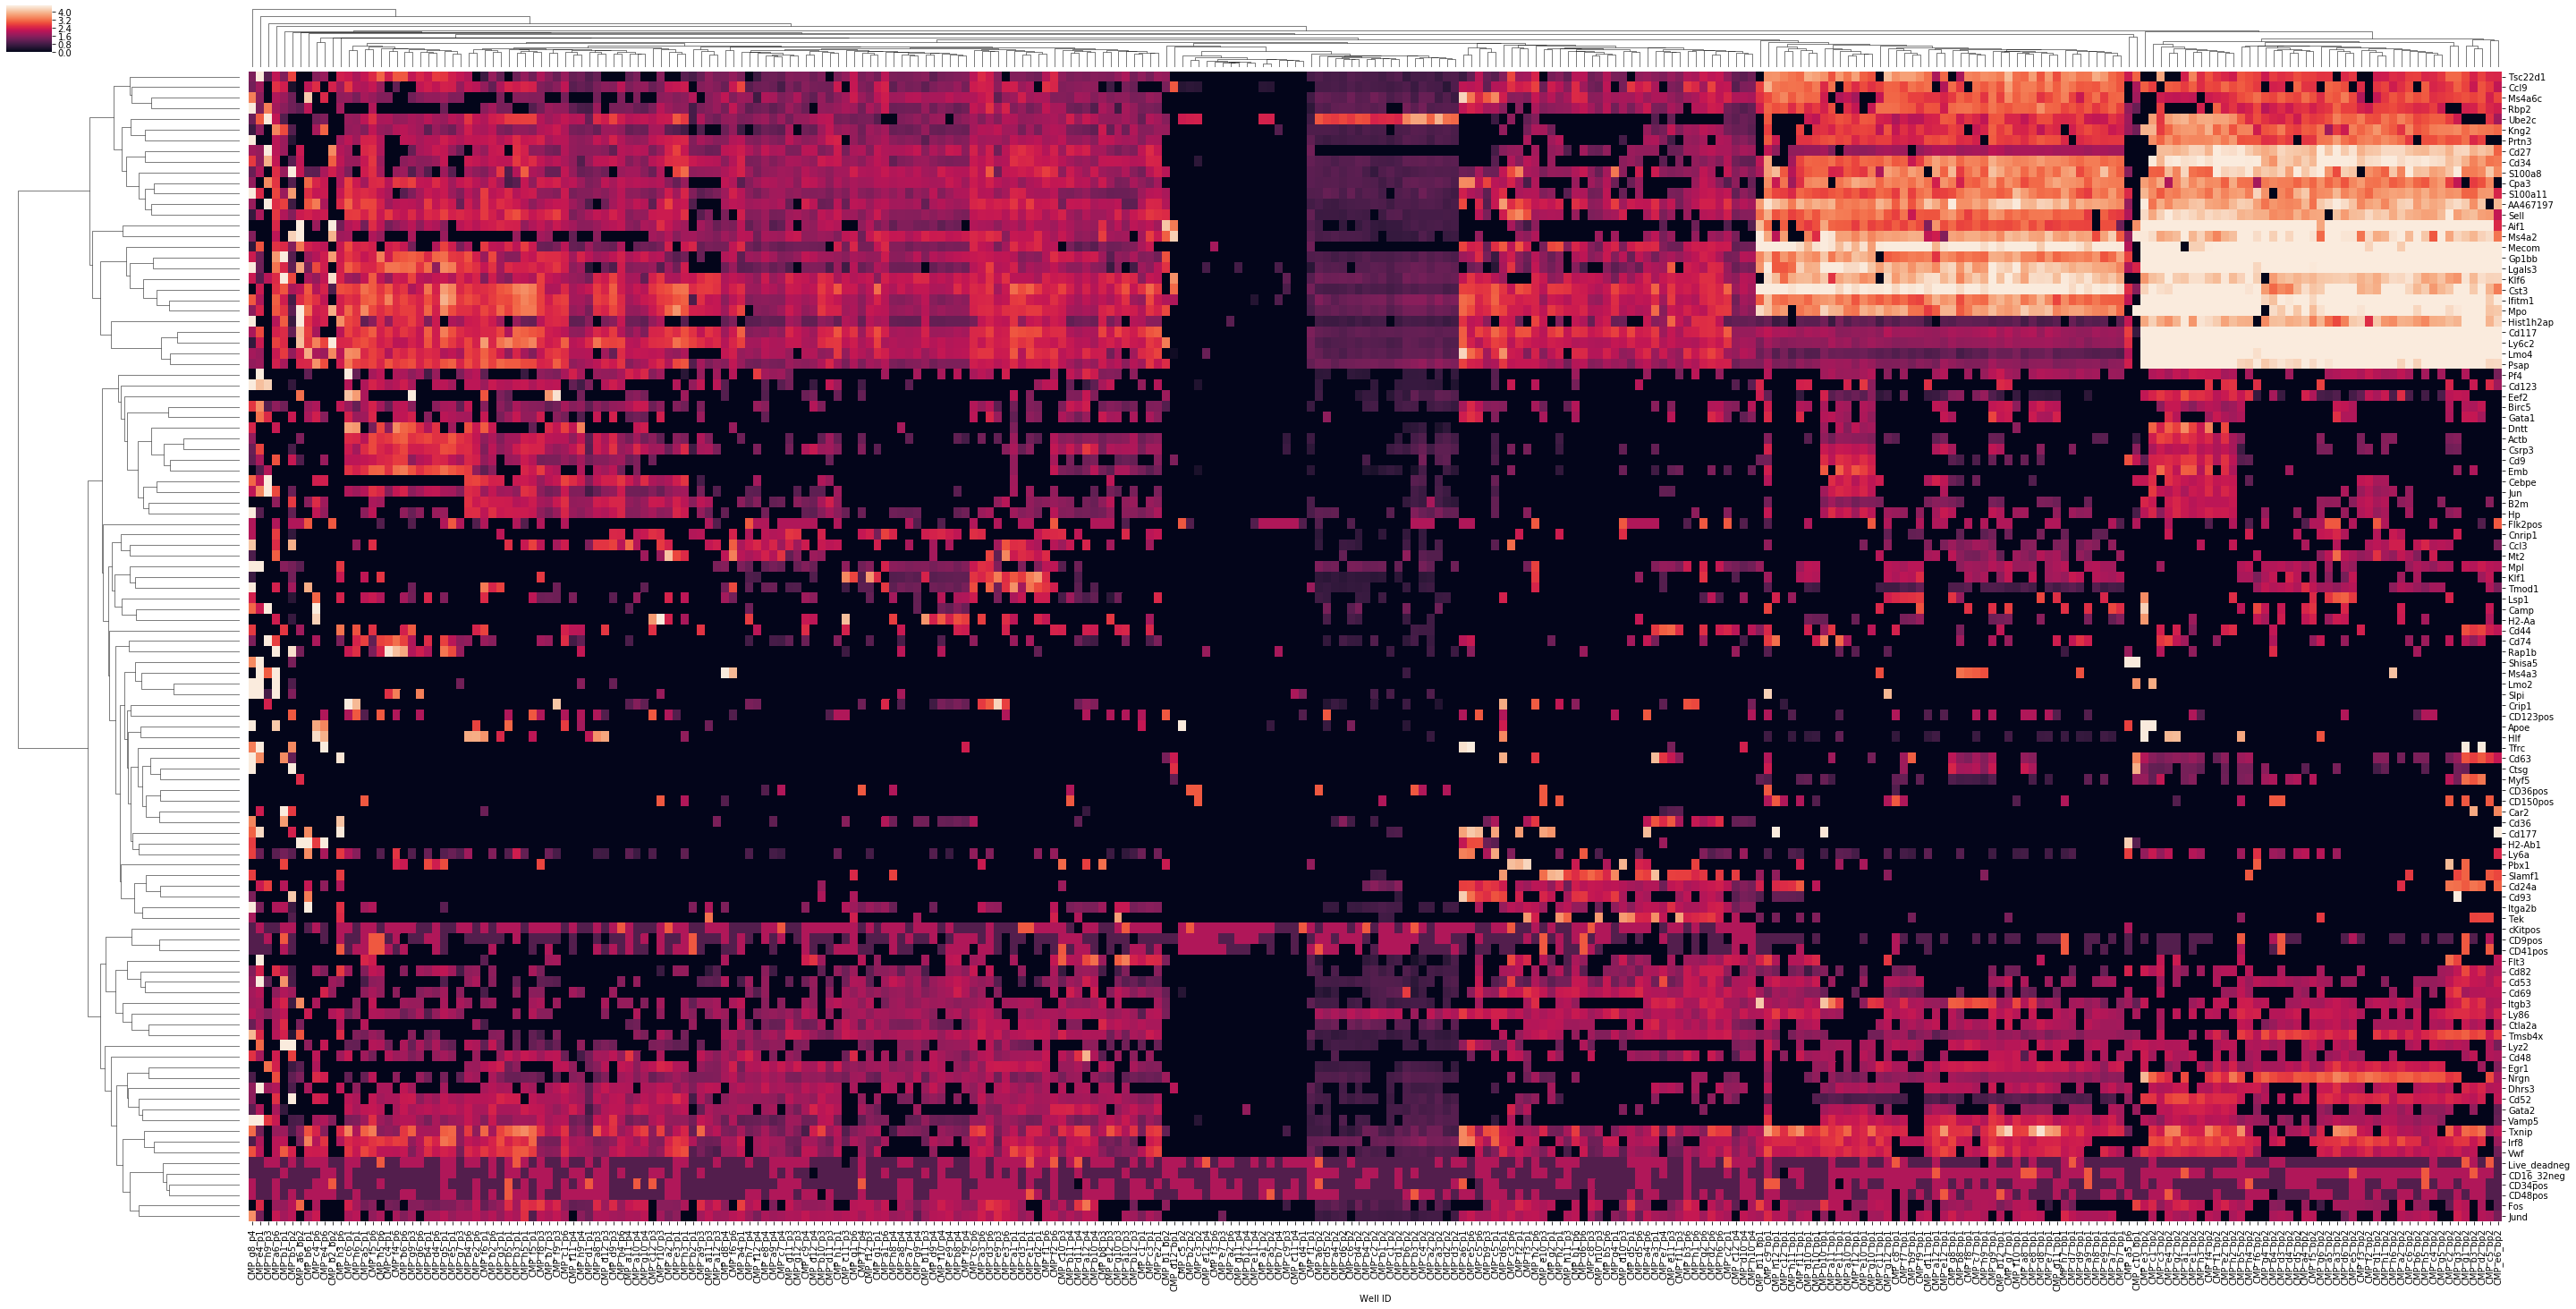

In [87]:
sns.clustermap(cmp_integrated_binned.transpose(), figsize=(50,25), method = 'average', robust = True, xticklabels = True, yticklabels = True)
savefig("CMP_integrated_binnedT_avg_norm.png", dpi = 400)

<a id='PlottSNEData'></a>

# Plotting Data as tSNE

In [30]:
biomark_ct.head()

,CMP_a1_p1,CMP_a2_p1,CMP_a3_p1,CMP_a4_p1,CMP_a5_p1,CMP_a6_p1,CMP_b1_p1,CMP_b2_p1,CMP_b3_p1,CMP_b4_p1,...,LSK_g12_bp2,LSK_g7_bp2,LSK_g8_bp2,LSK_g9_bp2,LSK_h10_bp2,LSK_h11_bp2,LSK_h12_bp2,LSK_h7_bp2,LSK_h8_bp2,LSK_h9_bp2
AA467197,2.043764,2.160861,0,1.698334,2.085589,0,0,0.983730,1.716377,2.123062,...,1.768498,0,1.626336,1.777007,0,1.754347,2.034381,0,1.690258,1.791676
Actb,2.470431,0.000000,0,1.901360,2.781268,0,0,0.000000,2.538366,0.000000,...,1.798647,0,2.313305,0.000000,0,1.501736,1.159211,0,2.448860,2.624673
Aif1,2.119391,2.338878,0,2.365541,1.354900,0,0,0.000000,2.431839,2.232919,...,2.358882,0,3.274982,3.342174,0,3.317778,0.000000,0,0.000000,3.520174
Apoe,0.000000,0.000000,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,...,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000
B2m,0.000000,1.995007,0,1.769719,0.000000,0,0,2.115063,2.044192,0.000000,...,0.000000,0,2.053378,1.745142,0,0.000000,0.000000,0,2.110914,1.866104


In [17]:
lskbiomark = biomark_ctrimmed.filter(regex = 'LSK')
cmpbiomark = biomark_ctrimmed.filter(regex = 'CMP')
mepbiomark = biomark_ctrimmed.filter(regex = 'MEP')

In [52]:
biomark_ctrimmed.head()

,CMP_a1_p1,CMP_a2_p1,CMP_a4_p1,CMP_a5_p1,CMP_b2_p1,CMP_b3_p1,CMP_b4_p1,CMP_b5_p1,CMP_b6_p1,CMP_c1_p1,...,LSK_f7_bp2,LSK_f9_bp2,LSK_g11_bp2,LSK_g12_bp2,LSK_g8_bp2,LSK_g9_bp2,LSK_h11_bp2,LSK_h12_bp2,LSK_h8_bp2,LSK_h9_bp2
AA467197,2.043764,2.160861,1.698334,2.085589,0.983730,1.716377,2.123062,1.856007,2.310176,1.759261,...,2.035255,1.672671,1.722724,1.768498,1.626336,1.777007,1.754347,2.034381,1.690258,1.791676
Actb,2.470431,0.000000,1.901360,2.781268,0.000000,2.538366,0.000000,2.561591,0.000000,2.063239,...,1.740659,2.529481,1.784432,1.798647,2.313305,0.000000,1.501736,1.159211,2.448860,2.624673
Aif1,2.119391,2.338878,2.365541,1.354900,0.000000,2.431839,2.232919,2.490423,0.000000,2.401583,...,3.140939,3.178109,3.526190,2.358882,3.274982,3.342174,3.317778,0.000000,0.000000,3.520174
Apoe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.172285,0.000000,1.793023,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B2m,0.000000,1.995007,1.769719,0.000000,2.115063,2.044192,0.000000,2.360978,1.629870,0.000000,...,0.000000,1.557165,0.000000,0.000000,2.053378,1.745142,0.000000,0.000000,2.110914,1.866104


In [198]:
from sklearn import datasets
digits = datasets.load_digits()
# Take the first 500 data points: it's hard to see 1500 points
X = digits.data[:500]
y = digits.target[:500]

In [204]:
type(digits.target)

array([0, 1, 2, ..., 8, 9, 8])

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [201]:
X_2d = tsne.fit_transform(X)

In [202]:
X_2d.shape

(500, 2)

In [203]:
digits.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

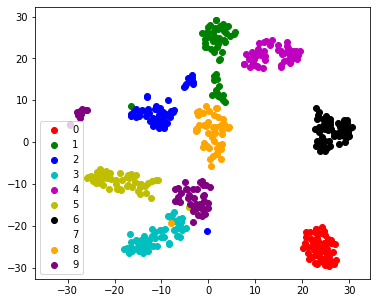

In [122]:
target_ids = range(len(digits.target_names))

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [15]:
# biomark_tsne = biomark_ctrimmed.transpose()
biomark_tsne = biomark_ctrimmed
array = biomark_tsne.to_numpy()
# array

In [16]:
biomark_tsne.head()

,CMP_a1_p1,CMP_a2_p1,CMP_a4_p1,CMP_a5_p1,CMP_b2_p1,CMP_b3_p1,CMP_b4_p1,CMP_b5_p1,CMP_b6_p1,CMP_c1_p1,...,LSK_f7_bp2,LSK_f9_bp2,LSK_g11_bp2,LSK_g12_bp2,LSK_g8_bp2,LSK_g9_bp2,LSK_h11_bp2,LSK_h12_bp2,LSK_h8_bp2,LSK_h9_bp2
AA467197,2.043764,2.160861,1.698334,2.085589,0.983730,1.716377,2.123062,1.856007,2.310176,1.759261,...,2.035255,1.672671,1.722724,1.768498,1.626336,1.777007,1.754347,2.034381,1.690258,1.791676
Actb,2.470431,0.000000,1.901360,2.781268,0.000000,2.538366,0.000000,2.561591,0.000000,2.063239,...,1.740659,2.529481,1.784432,1.798647,2.313305,0.000000,1.501736,1.159211,2.448860,2.624673
Aif1,2.119391,2.338878,2.365541,1.354900,0.000000,2.431839,2.232919,2.490423,0.000000,2.401583,...,3.140939,3.178109,3.526190,2.358882,3.274982,3.342174,3.317778,0.000000,0.000000,3.520174
Apoe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.172285,0.000000,1.793023,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B2m,0.000000,1.995007,1.769719,0.000000,2.115063,2.044192,0.000000,2.360978,1.629870,0.000000,...,0.000000,1.557165,0.000000,0.000000,2.053378,1.745142,0.000000,0.000000,2.110914,1.866104


In [19]:
george = tsne.fit_transform(array)

In [20]:
george.shape

(97, 2)

In [21]:
target_names = biomark_tsne.index
target_ids = range(len(target_names))
# target_ids
target_names

Index(['AA467197', 'Actb', 'Aif1', 'Apoe', 'B2m', 'Birc5', 'Camp', 'Car2',
       'Ccl3', 'Ccl9', 'Cd117', 'Cd123', 'Cd177', 'Cd24a', 'Cd27', 'Cd34',
       'Cd36', 'Cd44', 'Cd48', 'Cd52', 'Cd53', 'Cd63', 'Cd69', 'Cd74', 'Cd82',
       'Cd9', 'Cd93', 'Cebpe', 'Cnrip1', 'Cpa3', 'Crip1', 'Csrp3', 'Cst3',
       'Ctla2a', 'Ctsg', 'Dhrs3', 'Dntt', 'Eef2', 'Egr1', 'Emb', 'Flt3', 'Fos',
       'Gata1', 'Gata2', 'Gp1bb', 'H2-Aa', 'H2-Ab1', 'Hist1h2ap', 'Hlf', 'Hp',
       'Ifitm1', 'Irf8', 'Itga2b', 'Itgb3', 'Jun', 'Jund', 'Klf1', 'Klf6',
       'Kng2', 'Lgals3', 'Lmo2', 'Lmo4', 'Lsp1', 'Ly6a', 'Ly6c2', 'Ly86',
       'Lyz2', 'Mecom', 'Mpl', 'Mpo', 'Ms4a2', 'Ms4a3', 'Ms4a6c', 'Mt2',
       'Myf5', 'Nrgn', 'Pbx1', 'Pf4', 'Prtn3', 'Psap', 'Rap1b', 'Rbp2',
       'S100a11', 'S100a8', 'Sell', 'Shisa5', 'Slamf1', 'Slpi', 'Tek', 'Tfrc',
       'Tmod1', 'Tmsb4x', 'Tsc22d1', 'Txnip', 'Ube2c', 'Vamp5', 'Vwf'],
      dtype='object')

No handles with labels found to put in legend.


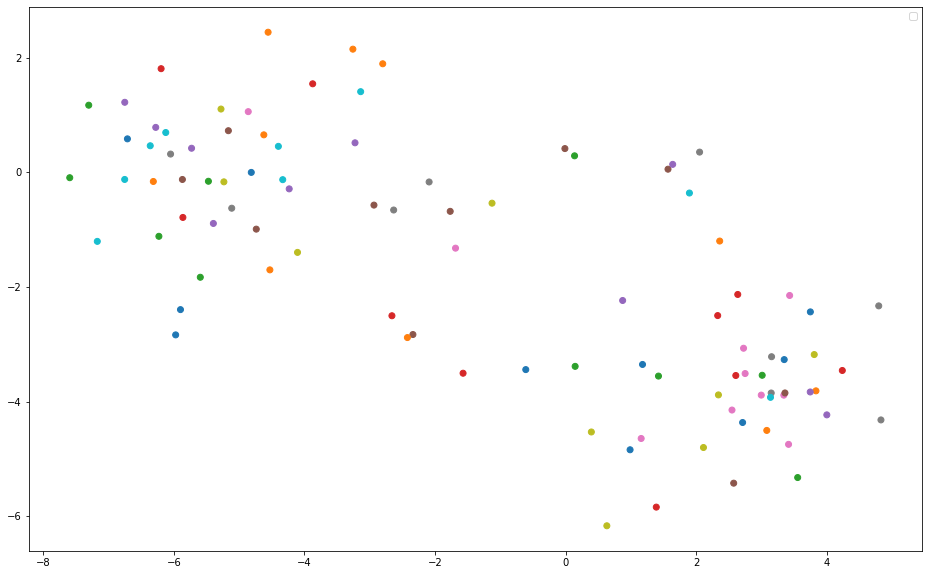

In [22]:
plt.figure(figsize=(16,10))
plt.scatter(x=george[:,0], y=george[:,1], c = sns.color_palette(n_colors = 97))
plt.legend()

In [173]:
target_ids = range(len(target_names))
print(target_ids)

range(0, 97)


In [43]:
for i, c, label in zip(target_ids, colors, target_names):
    print(i)
    print(c)
    print(label)

NameError: name 'colors' is not defined

In [42]:
for i, c, label in zip(range(0,97), colors, target_names):
    plt.scatter(george[target_names == i, 0], george[target_names == i, 1], c = c, label = label)


NameError: name 'colors' is not defined

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

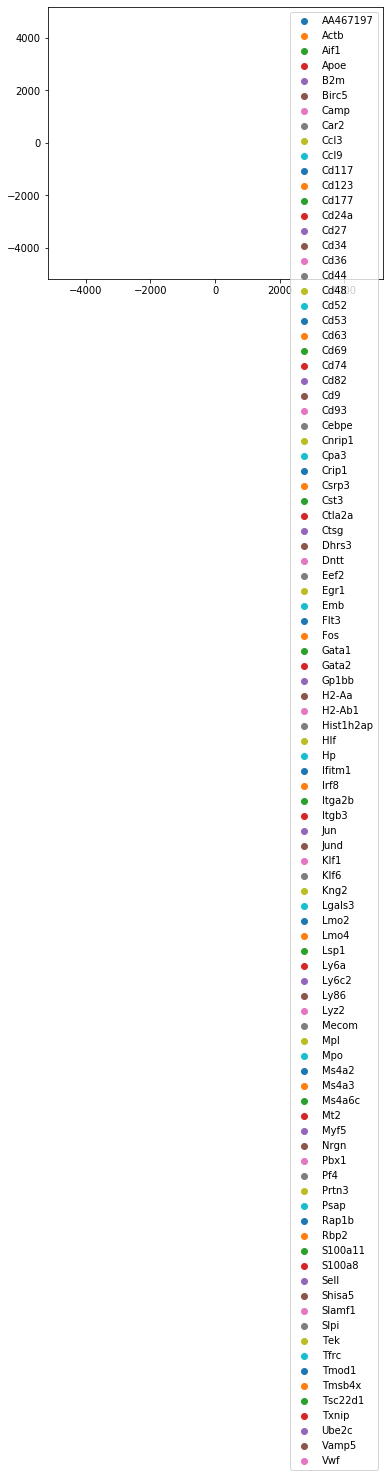

In [190]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = sns.color_palette(n_colors = 97)
for i, c, label in zip(range(0,97), colors, target_names):
    plt.scatter(george[target_names == i, 0], george[target_names == i, 1], c = c, label = label)
plt.legend()
plt.show()

<a id='tSNEofCells'></a>

## tSNE of LSK, CMP, and MEP

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [25]:
lsk_ctTrimmed = biomark_ctrimmed.filter(regex = 'LSK')
cmp_ctTrimmed = biomark_ctrimmed.filter(regex = 'CMP')
mep_ctTrimmed = biomark_ctrimmed.filter(regex = 'MEP')

No handles with labels found to put in legend.


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

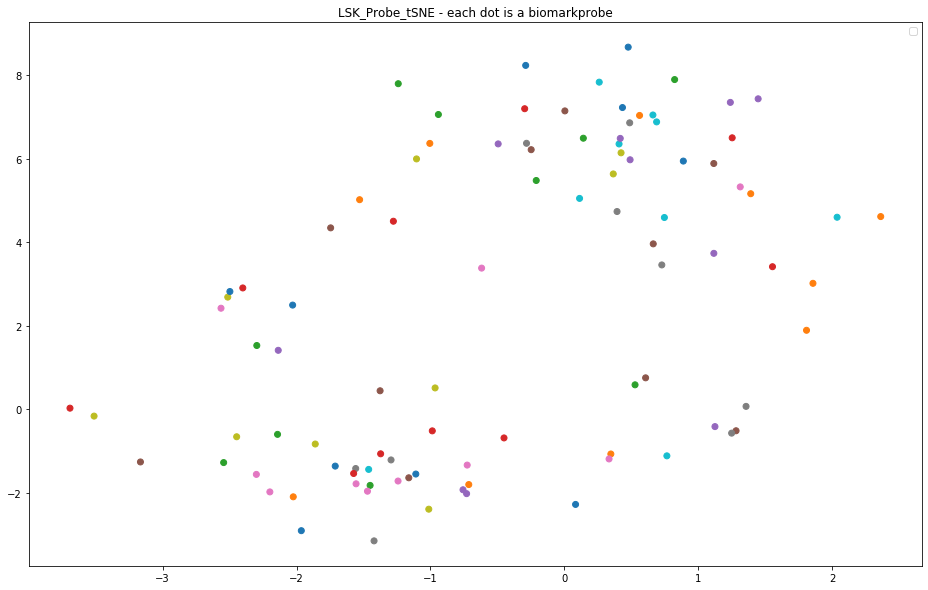

In [44]:
# lsk_tsne = lsk_ctTrimmed.transpose()
lsk_tsne = lsk_ctTrimmed
lsk_array = lsk_tsne.to_numpy()
# array
lsk_fit = tsne.fit_transform(lsk_array)
lsk_target_names = lsk_tsne.index
lsk_target_ids = range(len(lsk_target_names))
# target_ids
lsk_target_names
plt.figure(figsize=(16,10))
plt.scatter(x=lsk_fit[:,0], y=lsk_fit[:,1], c = sns.color_palette(n_colors = 97))
plt.legend()
plt.title("LSK_Probe_tSNE - each dot is a biomarkprobe")
plt.text(lsk_fit[:,0]+0.3, lsk_fit[:,1]+0.3, lsk_target_names)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'CMP_Probe_tSNE - each dot is a biomarkprobe')

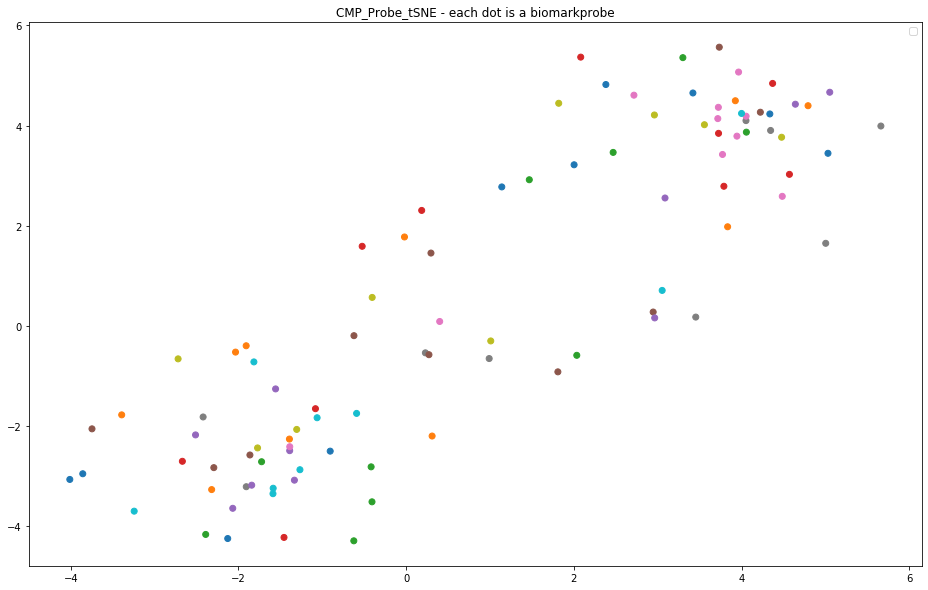

In [31]:
# cmp_tsne = cmp_ctTrimmed.transpose()
cmp_tsne = cmp_ctTrimmed
cmp_array = cmp_tsne.to_numpy()
# array
cmp_fit = tsne.fit_transform(cmp_array)
cmp_target_names = cmp_tsne.index
cmp_target_ids = range(len(cmp_target_names))
# target_ids
cmp_target_names
plt.figure(figsize=(16,10))
plt.scatter(x=cmp_fit[:,0], y=cmp_fit[:,1], c = sns.color_palette(n_colors = 97))
plt.legend()
plt.title("CMP_Probe_tSNE - each dot is a biomarkprobe")

No handles with labels found to put in legend.


Text(0.5, 1.0, 'MEP_Probe_tSNE - each dot is a biomarkprobe')

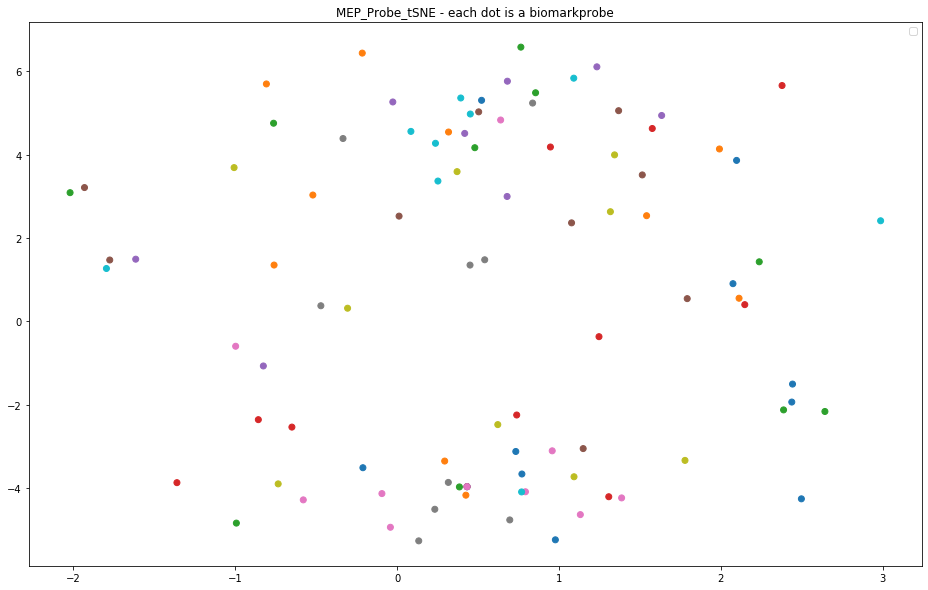

In [32]:
# mep_tsne = mep_ctTrimmed.transpose()
mep_tsne = mep_ctTrimmed
mep_array = mep_tsne.to_numpy()
# array
mep_fit = tsne.fit_transform(mep_array)
mep_target_names = mep_tsne.index
mep_target_ids = range(len(mep_target_names))
# target_ids
mep_target_names
plt.figure(figsize=(16,10))
plt.scatter(x=mep_fit[:,0], y=mep_fit[:,1], c = sns.color_palette(n_colors = 97))
plt.legend()
plt.title("MEP_Probe_tSNE - each dot is a biomarkprobe")

In [ ]:
df = cmp_alldata

In [ ]:
pca = PCA(n_components=3)
pca.fit(df)

In [ ]:
result = pd.DataFrame(pca.transform(df) ,columns=['PCA%i' % i for i in range(3)], index=df.index)

In [ ]:
# Run The PCA
pca = PCA(n_components=3)
pca.fit(df)
 
# Store results of PCA in a data frame
result=pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(3)], index=df.index)
 
# Plot initialisation
fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], cmap="Set2_r", s=100)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on CMP probe and fluorophore data")
plt.show()

## pca of all probe data

In [ ]:
biomark_ct = pd.read_excel("BiomarkExcels/20181023_BiomarkRun.xlsx", sheet_name="AllBioMarkStats")
celltypes = biomark_ct[['Well ID', 'Cell ID']]
celltypes = celltypes.drop_duplicates()
celltypes = celltypes.set_index('Well ID').sort_index()
celltypes.head(3)

In [ ]:
celltypes['categorical']= pd.Categorical(celltypes['Cell ID'])
my_color = celltypes['categorical'].cat.codes
# my_color

In [ ]:
all_probes = biomark_ctIndexed.transpose()
all_probes.head(3)

In [ ]:
df = all_probes
# Run The PCA
pca = PCA(n_components=3)
pca.fit(df)
 
# Store results of PCA in a data frame
result=pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(3)], index=df.index)
 
# Plot initialisation
fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c = my_color, cmap="Set2_r", s=100)
ax.legend(('LSK', 'CMP'))

# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on CMP probe and fluorophore data")

plt.show()

In [ ]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df)

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)
ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c = my_color, cmap="jet", s=100)
ax.legend(('LSK', 'CMP'))

<a id='20190809'></a>

## Applying Psaila et al. (Genome Biology, 2017) stringencies 
[Back to top](#top)